# "The effect of model resolution on air-sea CO$_{2}$ equilibration timescales "
## Code for Figure 1, 4 and 5
Corresponding to Yinghuan Xie (yinghuan.xie@utas.edu.au)

In [1]:
# Importing relevant modules.
import numpy as np
import xarray as xr
import time
import cftime
import datetime as dt
from datetime import timedelta
from datetime import datetime
import os
import re
from glob import glob
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

In [2]:
def find_output_containing_date(query_date_str, time_data):
    """
    Find the output index that contains the given date.
    :param query_date_str: The query date in 'YYYY-MM-DD' format. # Example usage: query_date = '2006-05-15'
    :param time_data: A dictionary mapping output indices to start and end times.
    :return: The index of the output containing the given date, or None if not found.
    """
    # Convert the input string to a datetime object
    query_date = datetime.strptime(query_date_str, "%Y-%m-%d")

    # Iterate over the time_data dictionary
    for output, (start_time, end_time, _) in time_data.items():
        # Check if the query date falls within the start and end times
        if start_time <= query_date <= end_time:
            return output
    
    # Return None if no containing output is found
    return None


def duration_calculator(initial_date,last_date):
    from datetime import datetime
    # Define the start and end dates
    initial_date = datetime(initial_date)#datetime(2004, 1, 1, 0, 0)
    last_date = datetime(last_date)#datetime(2019, 7, 1, 0, 0)
    # Calculated date interval
    delta = last_date - initial_date
    # Initialize the year month day difference
    year_diff = last_date.year - initial_date.year
    month_diff = last_date.month - initial_date.month
    day_diff = last_date.day - initial_date.day
    # Adjust the difference between month and day
    if day_diff < 0:
        # Obtains the number of days in the previous month
        day_in_previous_month = (initial_date + delta).day
        day_diff += day_in_previous_month
        month_diff -= 1
    if month_diff < 0:
        month_diff += 12
        year_diff -= 1
    return (year_diff, month_diff, day_diff)

def sort_and_deduplicate(group): 
    # Custom functions for sorting and de-weighting
    # Sort by Model time
    sorted_group = group.sort_values(by=[' Model time', ' Calculation time'])
    # The records with repeated Model time are removed, and only the records with the latest Calculation time are retained
    deduplicated_group = sorted_group.drop_duplicates(subset=' Model time', keep='last')
    return deduplicated_group

def get_res_value(char):
    if char.startswith("1deg_j"):
        return '1'
    elif char.startswith("01deg_"):
        return '0.1'
    elif char.startswith("025deg"):
        return '0.25'
    else:
        return None  # If it does not match any known pattern, return None or another default value


def adjust_year(time_value, start_year=2004, base_year=347):
    # Converts the 'time' coordinate to a datetime object and modifies the year to start from 2004
    if isinstance(time_value, cftime.DatetimeNoLeap):
        year_diff = time_value.year - base_year
        return time_value.replace(year=start_year + year_diff)
    else:
        year_diff = time_value.year - base_year
        return time_value.replace(year=start_year + year_diff)


# Declare and load global variables

In [3]:
# Manually assign working directory
local_dir = '/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files'
main_directory = f'{local_dir}/Analysis_&_result'

# Do not edit below
sites_ordered_labels=['Iceland','Ross Sea','Weddell Sea','Eastern Antarctica','Kuroshio Current','Gulf Stream','Western Australia','Tasmania','West of Gibraltar','Hawaii','Amazon','South China Sea']
exp_hemi =  {'02':'S','03':'N','04':  'S', '05': 'N','06':'S','07':'S','08':'N','09':'S','10':'S','11':'N','12':'S','13':'S', '16':'S','17':'N','18':'N','21':'N' }
exp_name =  {'02':'Eastern Australia','03':'Hawaii','04':  'Amazon', '05': 'Iceland','06':'Ross Sea','07':'Western Australia','08':'South China Sea','09':'Chile','10':'Brazil','11':'Eastern India','12':'Weddell Sea','13':'Eastern Antarctica', '16':'Tasmania','17':'Kuroshio Current','18':'West of Gibraltar','21':'Gulf Stream'}
exp_name_1 =  {2:'Eastern Australia',3:'Hawaii',4:  'Amazon', 5: 'Iceland',6:'Ross Sea',7:'Western Australia',8:'South China Sea',9:'Chile',10:'Brazil',11:'Eastern India',12:'Weddell Sea',13:'Eastern Antarctica', 16:'Tasmania',17:'Kuroshio Current',18:'West of Gibraltar',21:'Gulf Stream'}

sites_ordered_labels=['Iceland','Ross Sea','Weddell Sea','Eastern Antarctica','Kuroshio Current','Gulf Stream','Western Australia','Tasmania','West of Gibraltar','Hawaii','Amazon','South China Sea']

site_color = {'Iceland':'b','Ross Sea':'royalblue','Weddell Sea':'deepskyblue','Eastern Antarctica':'lightskyblue',
              'Kuroshio Current':'g','Gulf Stream':'limegreen',
              'Western Australia':'gold','Tasmania':'orange','West of Gibraltar':'goldenrod',
              'Hawaii':'orangered','Amazon':'crimson','South China Sea':'red'}

# Load very fine 1/10 degree DIC deficit values, which is slightly different from 0.25Tmol. 
# This issue does not exist in 0.25 and 1-degree experiment.
file_path = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result/01deg_REAL_Deficit_Calculation/01deg_REAL_Deficit_Calculation.csv'  
df = pd.read_csv(file_path)
# Convert the Calculation time column to datetime format
df['Calculation time'] = pd.to_datetime(df['Calculation time'])
# Group by Site No and select the row with the latest Calculation time
all_tar_data_records = df.loc[df.groupby('Site No')['Calculation time'].idxmax()]
# Record the result in the dictionary
Real_DIC_dict = dict(zip(all_tar_data_records['Site No'], all_tar_data_records['Real DIC deficit'].astype(float)))


# Load datasets

## Load Bach et al., 2023 dataset
Dataset has been summarized by Y.Xie

In [4]:
# Read pickle dataset
with open(f'{local_dir}/Inter-model_comparsion_files/BachETAL2023/BachETAL2023.pkl', 'rb') as pkl_file:
    BachETAL2023 = pickle.load(pkl_file)

## Load ACCESS-OM2 experiment equilibration timeseries data
### 12 Sites main experiments

In [5]:
Results_3Res_All_sites = {}

All_exp_dirs = ['1deg_jra55_iaf_spin_up_step_5400s_Group_1', '025deg_jra55_iaf_cycle_7_Group1' ,'01deg_jra55_iaf_group1_attempt_2',
                '1deg_jra55_iaf_spin_up_step_5400s_Group_2', '025deg_jra55_iaf_cycle_7_Group2' ,'01deg_jra55_iaf_group2'    ,
                '1deg_jra55_iaf_spin_up_step_5400s_Group_3', '025deg_jra55_iaf_cycle_7_Group3' ,'01deg_jra55_iaf_group3'    ,
                '1deg_jra55_iaf_spin_up_step_5400s_Group_4', '025deg_jra55_iaf_cycle_7_Group4' ,'01deg_jra55_iaf_Group4_3sites_adic_deficit_2004_07_01_07']

for file_path in All_exp_dirs:
    res = get_res_value(file_path[:6])
    # Use the glob module to find all CSV files that match the pattern
    csv_files = glob(os.path.join(main_directory+'/'+file_path, '*_DIC_deficit.csv'))

    # Check whether the number of CSV files found is 1
    if len(csv_files) != 1:
        raise FileNotFoundError(f"Expected exactly one CSV file in {file_path}, but found {len(csv_files)}.")

    # Read the only CSV file
    csv_file = csv_files[0]
    df = pd.read_csv(csv_file)

    unique_sites = df["Site No"].unique()
    grouped = df.groupby('Site No') 
    
    result = df.groupby('Site No', as_index=False).apply(sort_and_deduplicate)
    result = result.reset_index(drop=True)

    # Convert the column to the appropriate data type
    result[" Model time"] = pd.to_datetime(result[" Model time"])
    # Converts 'DIC deficit' to a numeric type and non-numeric values to NaN
    result[" DIC deficit"] = pd.to_numeric(result[" DIC deficit"], errors='coerce')
    # Remove the NaN value in 'DIC deficit'
    result = result.dropna(subset=[" DIC deficit"])
    result[" DIC deficit"] = result[" DIC deficit"].astype(float)


    for site in unique_sites:
        if len(site)<3:
            # Find the corresponding non-restart version of Site No
            original_site = site.replace("Restart_", "")
            if original_site in unique_sites:
                original_data = result[result["Site No"] == original_site]
                restart_data = result[result["Site No"] == 'Restart_'+original_site]
    
                # Check whether site is in the dictionary, if not, create it
                if site not in Results_3Res_All_sites:
                    Results_3Res_All_sites[site] = {}
                
                # Check whether res is in the site dictionary, and if not, create it
                if res not in Results_3Res_All_sites[site]:
                    Results_3Res_All_sites[site][res] = {}
            
                # Add data as new element in the corresponding 'res' key
                Results_3Res_All_sites[site][res]['original_data'] = original_data
                Results_3Res_All_sites[site][res]['restart_data'] = restart_data

# Review loaded sites
for key in Results_3Res_All_sites.keys():
    print('Loaded site: ',key,' with resolutions: ',list(Results_3Res_All_sites[key].keys()))

Loaded site:  4  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  7  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  12  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  5  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  16  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  17  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  6  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  8  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  18  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  3  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  13  with resolutions:  ['1', '0.25', '0.1']
Loaded site:  21  with resolutions:  ['1', '0.25', '0.1']


### Additional test experiments for Hawaii, Iceland, Kuroshio and Europe site with 1-degree resolution.

In [6]:
Results_3Res_All_sites_2004_01_H_I_K_E = {}

All_exp_dirs = ['1deg_jra55_iaf_spin_up_step_5400s_Special_Group_Iceland_Hawaii_Jan_release',
                '1deg_jra55_iaf_spin_up_step_5400s_Special_Group_Kuroshio_Europe_Jan_release']

for file_path in All_exp_dirs:
    res = get_res_value(file_path[:6])
    # Use the glob module to find all CSV files that match the pattern
    csv_files = glob(os.path.join(main_directory+'/'+file_path, '*_DIC_deficit.csv'))

    # Check whether the number of CSV files found is 1
    if len(csv_files) != 1:
        raise FileNotFoundError(f"Expected exactly one CSV file in {file_path}, but found {len(csv_files)}.")

    # Read the only CSV file
    csv_file = csv_files[0]
    df = pd.read_csv(csv_file)

    unique_sites = df["Site No"].unique()
    grouped = df.groupby('Site No') 

    result = df.groupby('Site No', as_index=False).apply(sort_and_deduplicate)
    result = result.reset_index(drop=True)
    
    # Convert the column to the appropriate data type
    result[" Model time"] = pd.to_datetime(result[" Model time"])
    # Converts 'DIC deficit' to a numeric type and non-numeric values to NaN
    result[" DIC deficit"] = pd.to_numeric(result[" DIC deficit"], errors='coerce')
    # Remove the NaN value in 'DIC deficit'
    result = result.dropna(subset=[" DIC deficit"])
    result[" DIC deficit"] = result[" DIC deficit"].astype(float)

    for site in unique_sites:
        if len(site)<3:
            # Find the corresponding non-restart version of Site No
            original_site = site.replace("Restart_", "")
            if original_site in unique_sites:
                original_data = result[result["Site No"] == original_site]
                restart_data = result[result["Site No"] == 'Restart_'+original_site]
    
                # Check whether site is in the dictionary, if not, create it
                if site not in Results_3Res_All_sites_2004_01_H_I_K_E:
                    Results_3Res_All_sites_2004_01_H_I_K_E[site] = {}
                
                # Check whether res is in the site dictionary, and if not, create it
                if res not in Results_3Res_All_sites_2004_01_H_I_K_E[site]:
                    Results_3Res_All_sites_2004_01_H_I_K_E[site][res] = {}
            
                # Add data as new element in the corresponding 'res' key
                Results_3Res_All_sites_2004_01_H_I_K_E[site][res]['original_data'] = original_data
                Results_3Res_All_sites_2004_01_H_I_K_E[site][res]['restart_data'] = restart_data

# Review loaded sites
for key in Results_3Res_All_sites_2004_01_H_I_K_E.keys():
    print('Loaded site: ',key,' with resolutions: ',list(Results_3Res_All_sites_2004_01_H_I_K_E[key].keys()))

Loaded site:  3  with resolutions:  ['1']
Loaded site:  5  with resolutions:  ['1']
Loaded site:  17  with resolutions:  ['1']
Loaded site:  18  with resolutions:  ['1']


### Quick summary of equilibration at given time with the given resolution
Not necessary part for following chunks

## Load Zhou&Tyka et al., 2024 dataet
Note: the csv dataset loading below is generated from "ZhouTykaETAL2024_TemperolCurves.ipynb"

In [7]:
oae_eff_curves_global = xr.open_dataset(
    f'{local_dir}/Inter-model_comparsion_files/ZhouTykaETAL2024/oae_eff_curves_global.nc')
summarize = pd.read_csv(
    f'{local_dir}/Inter-model_comparsion_files/ZhouTykaETAL2024/summarize.csv')
summarize_Hawaii_Iceland_Kuroshio_Europe_Jan = pd.read_csv(
    f'{local_dir}/Inter-model_comparsion_files/ZhouTykaETAL2024/summarize_Hawaii_Iceland_Kuroshio_Europe_Jan.csv')

## Read He and Tyka 2023 dataset

In [8]:
HeTyka = pd.read_hdf(f'{local_dir}/Inter-model_comparsion_files/HeTyka2023/he_tyka_uptake_curves.h5', mode='r')

# Plot main equilibration timeseries and corresponding rate for Figure 1 (b)

## Plot main equilibration timeseries and corresponding rate

ZhouTyka2024  Amazon
index: 5
index: 6
index: 7
index: 8
mean_site_eta_max:  0.7918343708347801
BachETAL2023  Amazon
HeTyka2023  Amazon


/jobfs/131847790.gadi-pbs/ipykernel_355857/2606610734.py:193: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected


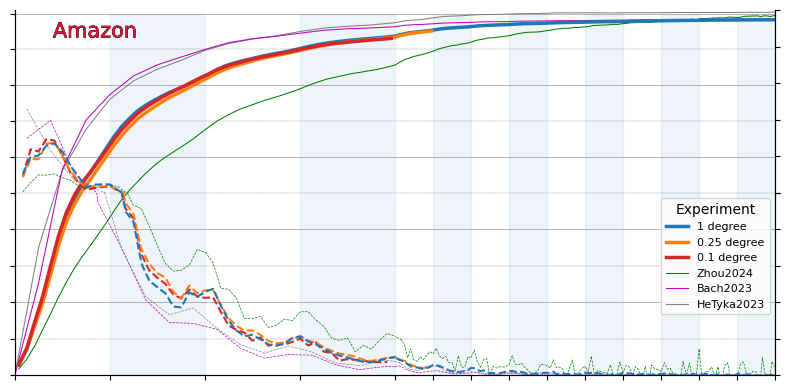

ZhouTyka2024  Western Australia


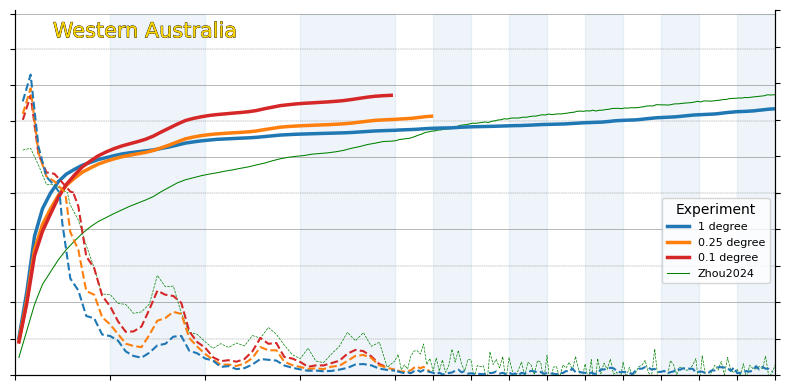

ZhouTyka2024  Weddell Sea


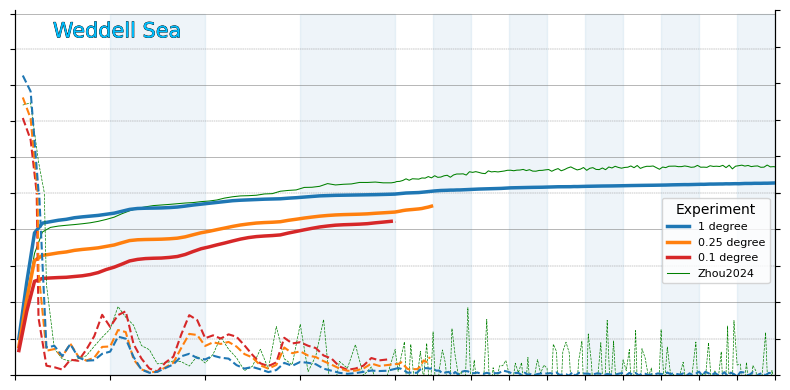

ZhouTyka2024  Iceland


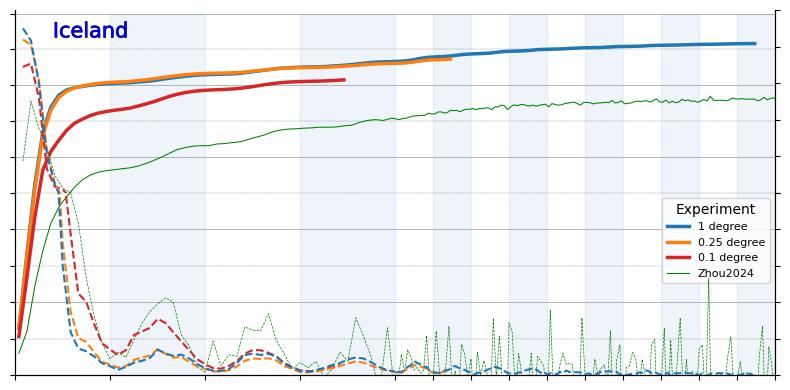

ZhouTyka2024  Tasmania
index: 35
index: 36
index: 37
mean_site_eta_max:  0.8426677370075748
HeTyka2023  Tasmania


/jobfs/131847790.gadi-pbs/ipykernel_355857/2606610734.py:193: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected


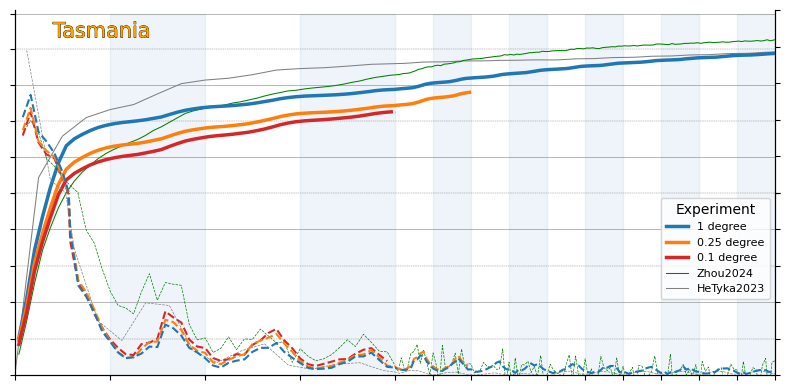

ZhouTyka2024  Kuroshio Current


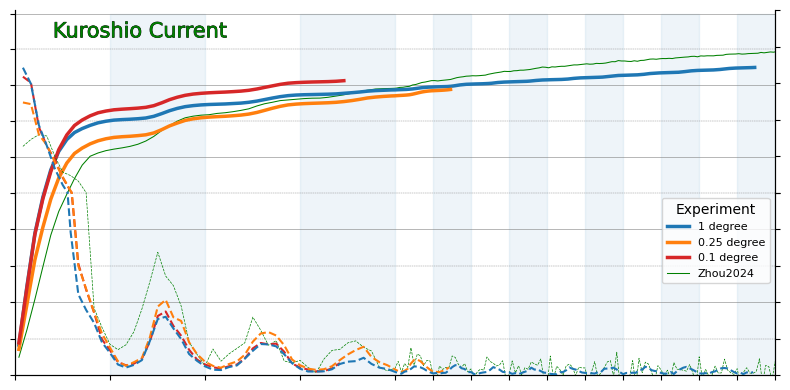

ZhouTyka2024  Ross Sea


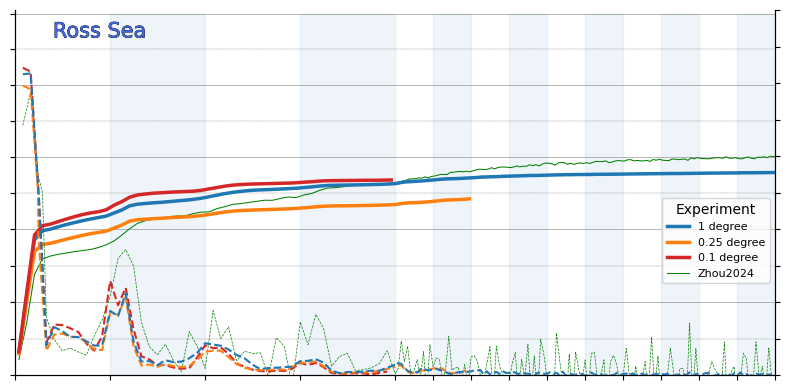

ZhouTyka2024  South China Sea


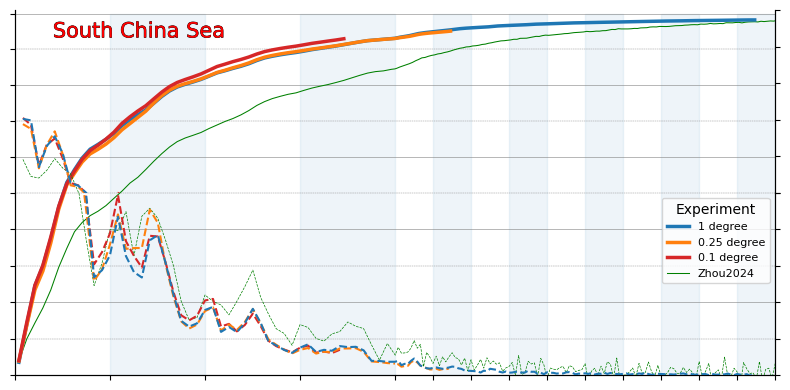

ZhouTyka2024  West of Gibraltar


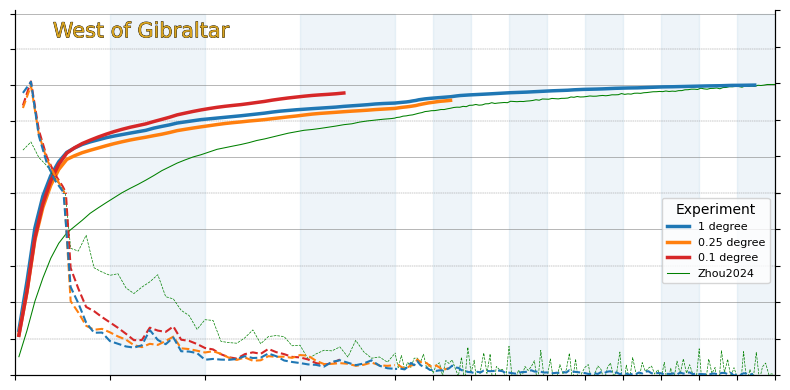

ZhouTyka2024  Hawaii


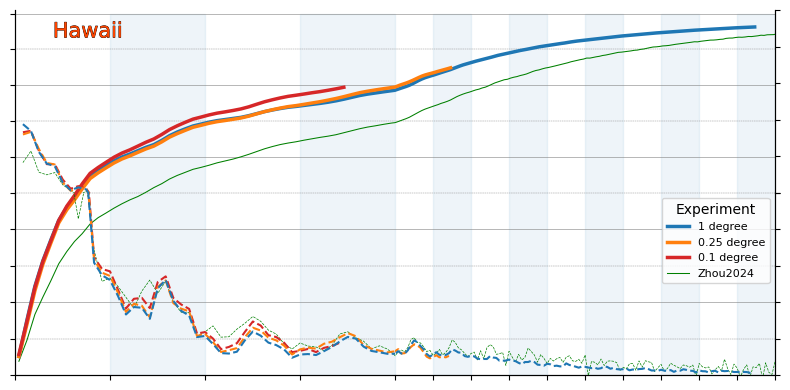

ZhouTyka2024  Eastern Antarctica


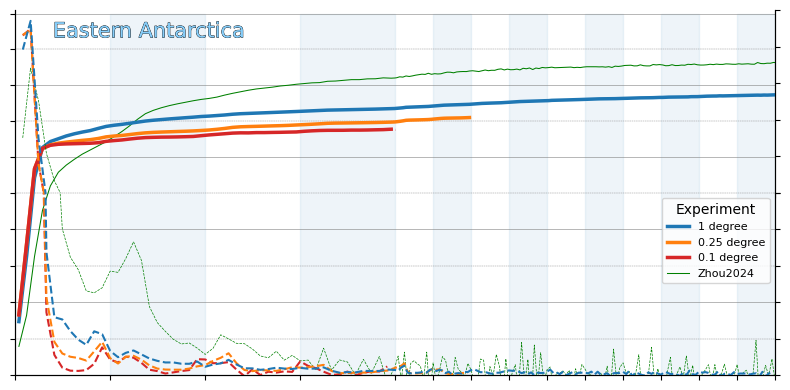

ZhouTyka2024  Gulf Stream


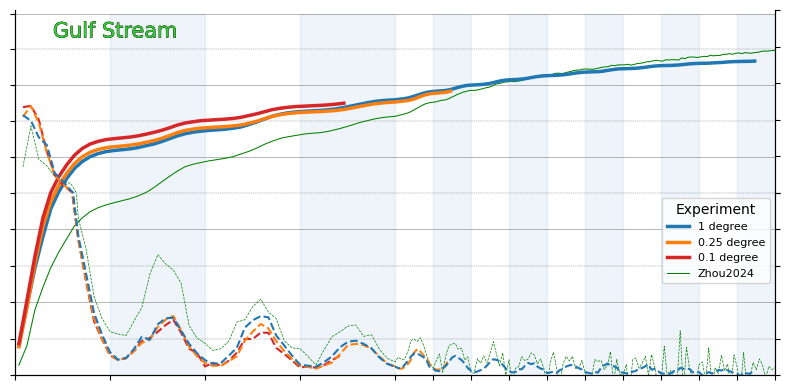

In [26]:
import matplotlib.patheffects as path_effects

# Settings & flags
y_secondary_range=[0,2.5,22.5]
access_curve_linewidth = 2.5
other_curve_linewidth = 0.75
access__diff_curve_linewidth = 1.5
other__diff_curve_linewidth = 0.5

label_flag             = False
first_month_correction = True
restart_of_01          = False
ZhouTyka2024           = True
use_BachETAL2023       = True
use_HeTyka             = True
First_5_yrs            = False
SaveFlag               = True
all_ZhouTyka           = False
Tide_no_label_version  = True

import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Iterate through each site and generate a separate image
for i, site in enumerate(Results_3Res_All_sites):
    RunNo = str("{:02}".format(int(site)))
    
    fig, axes = plt.subplots(2, 2, figsize=(8,4), gridspec_kw={"wspace": 0.0, "hspace": 0.0})
    ax_left, ax_right, ax_left_bottom, ax_right_bottom = axes.flatten()
    
    #Bond all x and y axis for each subplots
    ax_left_secondary = ax_left.twinx()
    ax_right_secondary = ax_right.twinx()
    ax_left_bottom_secondary = ax_left_bottom.twinx()
    ax_right_bottom_secondary = ax_right_bottom.twinx()

    for res in Results_3Res_All_sites[site]:
        original_data = Results_3Res_All_sites[site][res]['original_data']

        if (res == '0.1') and restart_of_01:
            restart_data = Results_3Res_All_sites[site][res]['restart_data']
        
        # Converts time data to date-time format
        original_data[' Model time'] = pd.to_datetime(original_data[' Model time'])
        
        # Set the time mask
        if exp_hemi[RunNo] == 'S':
            start_date = '2004-01-01'
            mask1 = (original_data[' Model time'] >= '2004-01-01')
            if res == '0.1':
                mask1 = (original_data[' Model time'] >= '2004-01-01') & (original_data[' Model time'] < '2008-01-01')
        elif exp_hemi[RunNo] == 'N':
            start_date = '2004-07-01'
            mask1 = (original_data[' Model time'] >= '2004-07-01')
            if res == '0.1':
                mask1 = (original_data[' Model time'] >= '2004-07-01') & (original_data[' Model time'] < '2008-01-01')
        
        # Calculate the percentage of DIC deficit
        if res == '1':
            deficit_in_precentage = 100 - original_data[' DIC deficit'][mask1] * 100 / 2.5e14
            if first_month_correction:
                deficit_in_precentage.values[0] = 100 - original_data[' DIC deficit'][mask1].values[0] * 100 / (2.5e14/2)
            for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                axe.plot(original_data[' Model time'][mask1], deficit_in_precentage, linestyle='-', c='C0', label=f'{res} degree', linewidth=access_curve_linewidth, zorder=17)

            # Calculate the difference and plot it
            differences = np.diff(deficit_in_precentage)
            differences_max = max(differences)
            times = original_data[' Model time'][mask1].values
            mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
            for axe in [ax_left_secondary,ax_right_bottom_secondary,ax_left_bottom_secondary,ax_right_secondary]:
                axe.plot(mid_points, differences, color='C0', linestyle='--', zorder=15, linewidth=access__diff_curve_linewidth)

        if res == '0.25':
            deficit_in_precentage = 100 - original_data[' DIC deficit'][mask1] * 100 / 2.5e14
            if first_month_correction:
                deficit_in_precentage.values[0] = 100 - original_data[' DIC deficit'][mask1].values[0] * 100 / (2.5e14/2)
            for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                axe.plot(original_data[' Model time'][mask1], deficit_in_precentage, linestyle='-', c='C1', label=f'{res} degree', linewidth=access_curve_linewidth, zorder=18)

            # Calculate the difference and plot it
            differences = np.diff(deficit_in_precentage)
            differences_max = max(differences_max,max(differences))
            times = original_data[' Model time'][mask1].values
            mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
            for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
                axe.plot(mid_points, differences, color='C1', linestyle='--', zorder=14,linewidth=access__diff_curve_linewidth)

        if res == '0.1':
            deficit_in_precentage = 100 - original_data[' DIC deficit'][mask1] * 100 / (Real_DIC_dict[int(site)])
            if first_month_correction:
                deficit_in_precentage.values[0] = 100 - original_data[' DIC deficit'][mask1].values[0] * 100 / ((Real_DIC_dict[int(site)]/2))
            for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                axe.plot(original_data[' Model time'][mask1], deficit_in_precentage , linestyle='-', c='C3', label=f'{res} degree', linewidth=access_curve_linewidth, zorder=19)
            # Calculate the difference and plot it
            differences = np.diff(deficit_in_precentage)
            differences_max = max(differences_max,max(differences))
            times = original_data[' Model time'][mask1].values
            mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
            for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
                axe.plot(mid_points, differences, color='C3', linestyle='--', zorder=13,linewidth=access__diff_curve_linewidth)

    if ZhouTyka2024:
        print('ZhouTyka2024 ', exp_name[RunNo])
        region_dic = {0: 'Pacific', 1: 'Atlantic', 2: 'South', 3: 'Southern_Ocean'}
        season_dic = {0: 'January', 1: 'April', 2: 'July', 3: 'October'}
        
        df = summarize[summarize['name'] == exp_name[RunNo]]
        curves = []
        curves_all = []
        
        for index, row in df.iterrows():
            data = oae_eff_curves_global.OAE_efficiency.sel(
                region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season]
            ) * 100 * row['contribution'] / row['eta_max']
            data_all = oae_eff_curves_global.OAE_efficiency.sel(
                region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season]
            ) * 100 / row['eta_max']
            
            # Use adjust_year function to adjust the time
            new_times = [adjust_year(time) for time in data['time'].values]
            # Convert new_times to pandas.DatetimeIndex
            new_times = pd.to_datetime([pd.Timestamp(time.isoformat()) for time in new_times])
            
            # Update the DataArray's 'time' coordinates
            data = data.assign_coords(time=new_times)
            data_all = data_all.assign_coords(time=new_times)
            curves_all.append(data_all)
            curves.append(data)
        # This is not for plotting Zhou et al., 2024 data but for getting eta_max for plotting He and Tyka 2023 data (chunk is below)
        if use_HeTyka and (exp_name[RunNo] in ['Amazon','Tasmania']):
            mean_site_eta_max = 0
            for index, row in df.iterrows():
                print('index:',index)
                mean_site_eta_max += row['contribution']* row['eta_max']
            print('mean_site_eta_max: ',mean_site_eta_max)
        
        # Plotting equilibration timeseries
        for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
            (sum(curves)).plot(ax=axe, c='g', label='Zhou2024', linewidth=other_curve_linewidth, linestyle='-', zorder=16)
        
        # Plotting equilibration rate (monthly difference from above equilibration) timeseries
        total_curve = sum(curves)
        differences = np.diff(total_curve)
        differences_max = max(differences_max,max(differences))
        times = total_curve['time'].values
        mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
        for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
            axe.plot(mid_points, differences, color='g', linestyle='--', zorder=12,linewidth=other__diff_curve_linewidth)
            
    if use_BachETAL2023:
        if exp_name[RunNo] in [ 'Amazon']:
            print('BachETAL2023 ', exp_name[RunNo])
            curve = BachETAL2023[exp_name[RunNo]]['curve'] * 100
            curve[0] = 0  # This is manually corrected
            if exp_hemi[RunNo] == 'S':
                for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                    axe.plot(BachETAL2023[exp_name[RunNo]]['time'], curve, c='m', label='Bach2023', linewidth=other_curve_linewidth, linestyle='-',zorder=15)
    
                # Plotting equilibration rate (monthly difference from above equilibration) timeseries
                differences = np.diff(curve)
                differences = differences/3
                differences_max = max(differences_max,max(differences))
                times = BachETAL2023[exp_name[RunNo]]['time']
                mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
                for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
                    axe.plot(mid_points, differences, color='m', linestyle='--', zorder=11,linewidth=other__diff_curve_linewidth)
    
            if exp_hemi[RunNo] == 'N':
                for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                    axe.plot(BachETAL2023[exp_name[RunNo]]['time_July'], curve, c='m', label='Bach2023 \n $^{*}$Jan release', linewidth=other_curve_linewidth, linestyle='-',zorder=15)
    
                # Plotting equilibration rate (monthly difference from above equilibration) timeseries
                differences = np.diff(curve)
                differences = differences/3
                differences_max = max(differences_max,max(differences))
                times = BachETAL2023[exp_name[RunNo]]['time_July']
                mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
                for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
                    axe.plot(mid_points, differences, color='m', linestyle='--', zorder=11,linewidth= other__diff_curve_linewidth)


    if use_HeTyka:
        Site_transition = {'Amazon':'brazil','Iceland':'island','Tasmania':'tasmania','Hawaii':'hawaii'}        
        if exp_name[RunNo] in [  'Amazon','Tasmania']:
            print('HeTyka2023 ', exp_name[RunNo])
            eta_max = np.max([mean_site_eta_max,np.nanmax(HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'])])
            curve = HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'] /mean_site_eta_max * 100
            time =  HeTyka.loc[Site_transition[exp_name[RunNo]]]['time']
            curve[0] = 0  # This is manually corrected
            if exp_hemi[RunNo] == 'S':
                time = pd.to_datetime('2004-01-01') + pd.to_timedelta(time * 365.25, unit='D')
            elif exp_hemi[RunNo] == 'N':
                time = pd.to_datetime('2004-07-01') + pd.to_timedelta(time * 365.25, unit='D')
                
            for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                axe.plot(time, curve, c='grey', label='HeTyka2023', linewidth=other_curve_linewidth, linestyle='-',zorder=14)

            # Plotting equilibration rate (monthly difference from above equilibration) timeseries
            differences = np.diff(curve)
            differences = differences/3
            differences_max = max(differences_max,max(differences))
            times = time
            mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
            for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
                axe.plot(mid_points, differences, color='grey', linestyle='--', zorder=11,linewidth=other__diff_curve_linewidth)

    

    # Set the title and label of the subplot
    if Tide_no_label_version:
        ax_left.set_title(f'')
        ax_left.text(0.1, 0.85, f'{exp_name[RunNo]}',color=site_color[exp_name_1[int(site)]], 
                transform=ax_left.transAxes, fontsize=15,
                path_effects=[
                    path_effects.Stroke(linewidth=0.5, foreground='black'),  # Black outline
                    path_effects.Normal()  # Normal text rendering
                ])
    else:
        ax_left.set_title(f'{exp_name[RunNo]}', x=1) #(Site No. {site})
    for axe in [ax_right,ax_left_bottom,ax_right_bottom]:
        axe.set_title(f'')
    

    # Set the Y-axis label to appear only in the left subplot
    ax_left.set_ylabel('Air-sea CO$_{2}$ equilibration (%)')
    ax_right_secondary.set_ylabel('Air-sea CO$_{2}$ monthly equilibration rate (%)')
    ax_left_bottom.set_xlabel('Year(s) after mCDR deployment')
    if Tide_no_label_version:
        ax_left.set_ylabel('')
        ax_right_secondary.set_ylabel('')
        ax_left_bottom.set_xlabel('')
    ax_left.yaxis.set_label_coords(-0.1, -0.05)
    ax_right_secondary.yaxis.set_label_coords(1.15, 0)
    ax_left_bottom.xaxis.set_label_coords(1, -0.17)
    
    ax_left_secondary.set_ylabel('')
    
    for axe in [ax_left_secondary,ax_left_bottom_secondary,ax_right,ax_right_bottom]:
        axe.set_yticks([])
        
    for axe in [ax_left_bottom,ax_left_bottom_secondary,ax_right,ax_right_bottom,ax_right_bottom_secondary]:
        axe.set_ylabel('')

    for axe in [ax_right,ax_left_bottom_secondary,ax_right_bottom]:
        axe.set_yticklabels([])
    for axe in [ax_right,ax_left]:
        axe.set_xticklabels([])
        
    for axe in [ax_right_secondary]:
        axe.set_yticks(np.arange(2.5,23,4))

    for axe in [ax_left_bottom,ax_right,ax_right_bottom,ax_left]:
        for y in np.arange(0,101,20):
            axe.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)
        for y in np.arange(10,101,20):
            axe.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='--',c='grey',zorder=1,linewidth=0.3)
    

    # Setting y limitations
    ax_left.set_ylim(50, 101) 
    ax_left.set_yticks(np.arange(60,101,10))
    ax_right.set_ylim(50, 101)  
    ax_left_bottom.set_ylim(0, 50)  
    ax_right_bottom.set_ylim(0, 50)  

    ax_left_secondary.set_ylim(y_secondary_range[1],y_secondary_range[2])
    ax_right_secondary.set_ylim(y_secondary_range[1],y_secondary_range[2])
    ax_left_bottom_secondary.set_ylim(0,y_secondary_range[1])
    ax_right_bottom_secondary.set_ylim(0,y_secondary_range[1])

    for ax in [ax_left, ax_right,ax_left_bottom,ax_right_bottom]:
        ax.tick_params(axis='x', rotation=0)        
    ax_left.set_xlabel('')
    ax_right.set_xlabel('')
    
    ax_right_bottom.set_xlabel('')

    # Change the x axis to the year starting from 2004
    if exp_hemi[RunNo] == 'S':
        ax_left.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_right.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2019-12-31'))
        
        ax_left_secondary.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_right_secondary.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2018-01-01'))
        
        ax_left_bottom.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_left_bottom.set_xticks(pd.date_range('2004-01-01', '2007-12-31', freq='AS-JAN'))
        ax_left_bottom.set_xticklabels([f'{i}' for i in range(0, 4)])
        
        ax_right_bottom.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2019-12-31'))
        ax_right_bottom.set_xticks(pd.date_range('2008-01-01', '2018-01-01', freq='AS-JAN'))
        ax_right_bottom.set_xticklabels([f'{i}' for i in range(4, 15)])
        
        ax_left_bottom_secondary.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_right_bottom_secondary.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2018-01-01'))
        
    elif exp_hemi[RunNo] == 'N':
        ax_left.set_xlim(pd.to_datetime('2004-07-01'), pd.to_datetime('2008-06-30'))
        ax_right.set_xlim(pd.to_datetime('2008-07-01'), pd.to_datetime('2018-07-01'))

        ax_left_secondary.set_xlim(pd.to_datetime('2004-07-01'), pd.to_datetime('2008-06-30'))
        ax_right_secondary.set_xlim(pd.to_datetime('2008-07-01'), pd.to_datetime('2018-07-01'))

        ax_left_bottom.set_xlim(pd.to_datetime('2004-07-01'), pd.to_datetime('2008-06-30'))
        ax_left_bottom.set_xticks(pd.date_range('2004-07-01', '2008-06-30', freq='AS-JUL'))
        ax_left_bottom.set_xticklabels([f'{i}' for i in range(0, 4)])
        
        ax_right_bottom.set_xlim(pd.to_datetime('2008-07-01'), pd.to_datetime('2018-07-01'))
        ax_right_bottom.set_xticks(pd.date_range('2008-07-01', '2018-07-01', freq='AS-JUL'))
        ax_right_bottom.set_xticklabels([f'{i}' for i in range(4, 15)])

        ax_left_bottom_secondary.set_xlim(pd.to_datetime('2004-07-01'), pd.to_datetime('2008-06-30'))
        ax_right_bottom_secondary.set_xlim(pd.to_datetime('2008-07-01'), pd.to_datetime('2018-07-01'))
        
    # Set the legend to be displayed only on the right subplot and placed in the upper right corner
    ax_right_bottom.legend(title='Experiment', loc='upper right',fontsize=8)

    for axe in [ax_right,ax_right_bottom,ax_right_secondary,ax_right_bottom_secondary]:
        axe.spines['left'].set_visible(False) 

    for axe in [ax_left,ax_left_bottom,ax_left_secondary,ax_left_bottom_secondary]:
        axe.spines['right'].set_visible(False) 

    for axe in [ax_left,ax_right,ax_left_secondary,ax_right_secondary]:
        axe.spines['bottom'].set_visible(False) 

    for axe in [ax_right_bottom,ax_right_bottom_secondary,ax_left_bottom,ax_left_bottom_secondary,ax_left,ax_right,ax_left_secondary,ax_right_secondary]:
        axe.spines['top'].set_visible(False)    

    for axe in [ax_right_bottom,ax_left_bottom,ax_left,ax_right]:
        if exp_hemi[RunNo] == 'S':
            mm=1
        elif exp_hemi[RunNo] == 'N':
            mm=7
        for year in np.arange(2005,2019,2):
            axe.fill_between([dt.datetime(year, mm, 1),dt.datetime(year+1, mm, 1)], [0,0],[100,100], alpha=0.075,zorder=0,color='C0')
        
    if Tide_no_label_version:
        for axe in [ax_left_bottom,ax_right_bottom]:
            axe.set_xticklabels([])
        for axe in [ax_left,ax_left_bottom,ax_right_bottom_secondary,ax_right_secondary]:
            axe.set_yticklabels([])

    # Save images for each site
    plt.tight_layout()
    if Tide_no_label_version:
        plt.savefig(f'{local_dir}/Figure1/Site_{site}_{exp_name[RunNo]}_Tide_ver.png',dpi=500)
    else:
        plt.savefig(f'{local_dir}/Figure1/Site_{site}_{exp_name[RunNo]}.png',dpi=500)
    plt.ioff()  # Turn off interactive mode
    plt.show()
    plt.close()

## Plot main equilibration timeseries and corresponding rate for Figure S1 (Januart tests)

ZhouTyka2024  Hawaii
index: 0
index: 1
index: 2
mean_site_eta_max:  0.8095055399591733
BachETAL2023  Hawaii
HeTyka2023  Hawaii


/jobfs/131636325.gadi-pbs/ipykernel_3551712/3359314187.py:142: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected


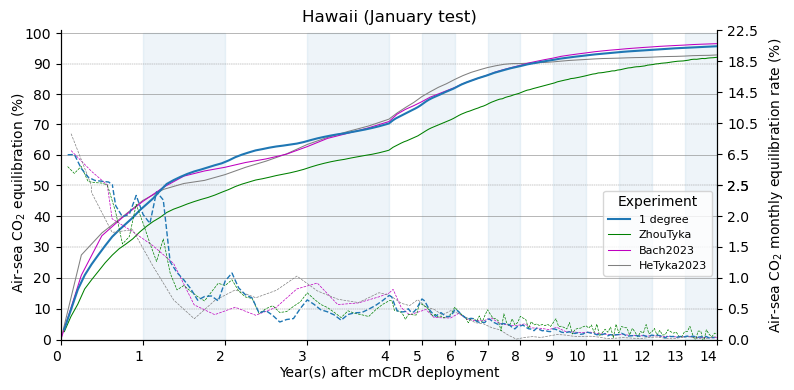

ZhouTyka2024  Iceland
index: 3
index: 4
index: 5
mean_site_eta_max:  0.8584666456952863
BachETAL2023  Iceland
HeTyka2023  Iceland


/jobfs/131636325.gadi-pbs/ipykernel_3551712/3359314187.py:142: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected


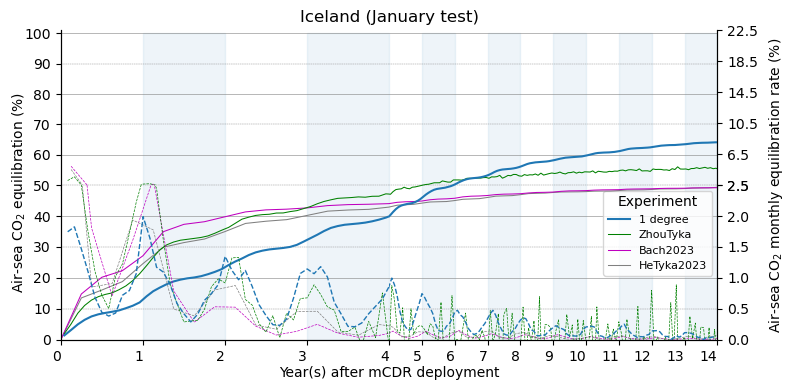

/jobfs/131636325.gadi-pbs/ipykernel_3551712/3359314187.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_data[' Model time'] = pd.to_datetime(original_data[' Model time'])
/jobfs/131636325.gadi-pbs/ipykernel_3551712/3359314187.py:142: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected


ZhouTyka2024  Kuroshio Current
index: 6
index: 7
mean_site_eta_max:  0.8397090175864744
HeTyka2023  Kuroshio Current


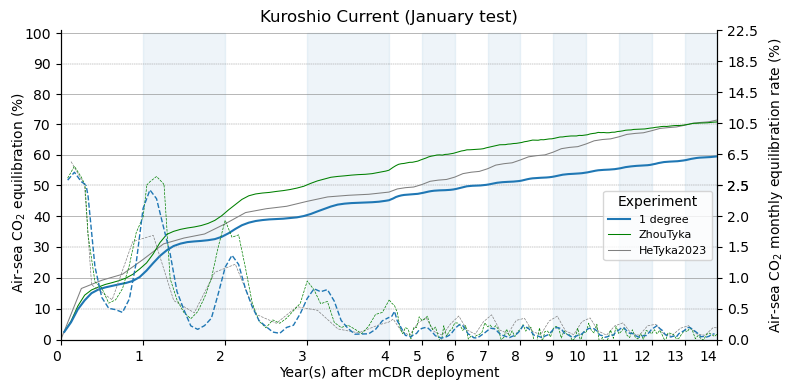

/jobfs/131636325.gadi-pbs/ipykernel_3551712/3359314187.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_data[' Model time'] = pd.to_datetime(original_data[' Model time'])
/jobfs/131636325.gadi-pbs/ipykernel_3551712/3359314187.py:142: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected


ZhouTyka2024  West of Gibraltar
index: 8
index: 9
mean_site_eta_max:  0.837443552273518
HeTyka2023  West of Gibraltar


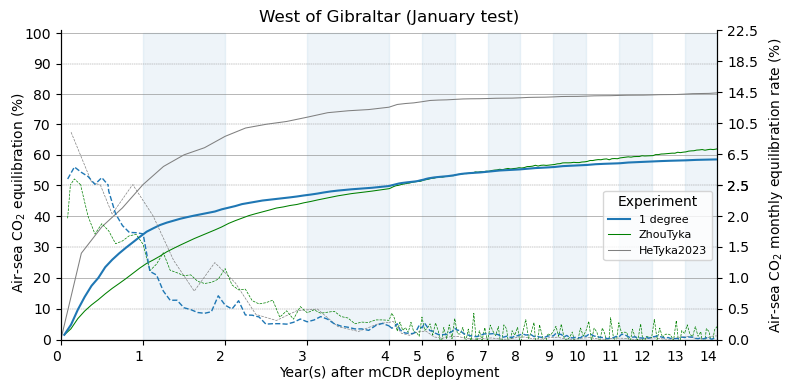

In [34]:
# Settings & flags
y_secondary_range=[0,2.5,22.5]
access_curve_linewidth = 1.5
other_curve_linewidth = 0.75
access__diff_curve_linewidth = 1
other__diff_curve_linewidth = 0.5

label_flag             = False
first_month_correction = True
restart_of_01          = False
ZhouTyka2024           = True
use_BachETAL2023       = True
use_HeTyka             = True
First_5_yrs            = False
SaveFlag               = True
all_ZhouTyka           = False

import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Iterate through each site and generate a separate image
for i, site in enumerate(['3','5','17','18',]):
    RunNo = str("{:02}".format(int(site)))
    
    fig, axes = plt.subplots(2, 2, figsize=(8,4), gridspec_kw={"wspace": 0.0, "hspace": 0.0})
    ax_left, ax_right, ax_left_bottom, ax_right_bottom = axes.flatten()
    
    # Bond all x and y axis for each subplots
    ax_left_secondary = ax_left.twinx()
    ax_right_secondary = ax_right.twinx()
    ax_left_bottom_secondary = ax_left_bottom.twinx()
    ax_right_bottom_secondary = ax_right_bottom.twinx()
    
    for res in Results_3Res_All_sites_2004_01_H_I_K_E[site]:
        original_data = Results_3Res_All_sites_2004_01_H_I_K_E[site][res]['original_data']

        if (res == '0.1') and restart_of_01:
            restart_data = Results_3Res_All_sites_2004_01_H_I_K_E[site][res]['restart_data']
        
        # Converts time data to date-time format
        original_data[' Model time'] = pd.to_datetime(original_data[' Model time'])
        
        # Set the time mask
        if exp_hemi[RunNo] == 'N':
            start_date = '2004-01-01'
            mask1 = (original_data[' Model time'] >= '2004-01-01')
            if res == '0.1':
                mask1 = (original_data[' Model time'] >= '2004-01-01') & (original_data[' Model time'] < '2008-01-01')
        
        # Calculate the percentage of DIC deficit
        if res == '1':
            deficit_in_precentage = 100 - original_data[' DIC deficit'][mask1] * 100 / 2.5e14
            if first_month_correction:
                deficit_in_precentage.values[0] = 100 - original_data[' DIC deficit'][mask1].values[0] * 100 / (2.5e14/2)
            for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                axe.plot(original_data[' Model time'][mask1], deficit_in_precentage, linestyle='-', c='C0', label=f'{res} degree', linewidth=access_curve_linewidth, zorder=17)

            # Calculate the difference and plot it
            differences = np.diff(deficit_in_precentage)
            differences_max = max(differences)
            times = original_data[' Model time'][mask1].values
            mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
            for axe in [ax_left_secondary,ax_right_bottom_secondary,ax_left_bottom_secondary,ax_right_secondary]:
                axe.plot(mid_points, differences, color='C0', linestyle='--', zorder=15, linewidth=access__diff_curve_linewidth)

    if ZhouTyka2024:
        print('ZhouTyka2024 ', exp_name[RunNo])
        region_dic = {0: 'Pacific', 1: 'Atlantic', 2: 'South', 3: 'Southern_Ocean'}
        season_dic = {0: 'January', 1: 'April', 2: 'July', 3: 'October'}
        
        df = summarize_Hawaii_Iceland_Kuroshio_Europe_Jan[summarize_Hawaii_Iceland_Kuroshio_Europe_Jan['name'] == exp_name[RunNo]]
        curves = []
        curves_all = []
        
        for index, row in df.iterrows():
            data = oae_eff_curves_global.OAE_efficiency.sel(
                region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season]
            ) * 100 * row['contribution'] / row['eta_max']
            data_all = oae_eff_curves_global.OAE_efficiency.sel(
                region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season]
            ) * 100 / row['eta_max']
            
            # Use adjust_year function to adjust the time
            new_times = [adjust_year(time) for time in data['time'].values]
            # Convert new_times to pandas.DatetimeIndex
            new_times = pd.to_datetime([pd.Timestamp(time.isoformat()) for time in new_times])
            
            # Update the DataArray's 'time' coordinates
            data = data.assign_coords(time=new_times)
            data_all = data_all.assign_coords(time=new_times)
            curves_all.append(data_all)
            curves.append(data)

        # This is not for plotting Zhou et al., 2024 data but for getting eta_max for plotting He and Tyka 2023 data (chunk is below)
        if use_HeTyka and (exp_name[RunNo] in ['Hawaii','Iceland','Kuroshio Current','West of Gibraltar']):
            mean_site_eta_max = 0
            for index, row in df.iterrows():
                print('index:',index)
                mean_site_eta_max += row['contribution']* row['eta_max']
            print('mean_site_eta_max: ',mean_site_eta_max)
        
        # Plotting equilibration timeseries
        for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
            (sum(curves)).plot(ax=axe, c='g', label='ZhouTyka', linewidth=other_curve_linewidth, linestyle='-', zorder=16)
        
        # Plotting equilibration rate (monthly difference from above equilibration) timeseries
        total_curve = sum(curves)
        differences = np.diff(total_curve)
        differences_max = max(differences_max,max(differences))
        times = total_curve['time'].values
        mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
        for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
            axe.plot(mid_points, differences, color='g', linestyle='--', zorder=12,linewidth=other__diff_curve_linewidth)
            
    if use_BachETAL2023:
        if exp_name[RunNo] in ['Hawaii', 'Iceland', 'Amazon']:
            print('BachETAL2023 ', exp_name[RunNo])
            curve = BachETAL2023[exp_name[RunNo]]['curve'] * 100
            curve[0] = 0  # This is manually corrected
            if exp_hemi[RunNo] == 'N':
                for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                    axe.plot(BachETAL2023[exp_name[RunNo]]['time'], curve, c='m', label='Bach2023', linewidth=other_curve_linewidth, linestyle='-',zorder=15)
    
                # Plotting equilibration rate (monthly difference from above equilibration) timeseries
                differences = np.diff(curve)
                differences = differences/3
                differences_max = max(differences_max,max(differences))
                times = BachETAL2023[exp_name[RunNo]]['time']
                mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
                for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
                    axe.plot(mid_points, differences, color='m', linestyle='--', zorder=11,linewidth=other__diff_curve_linewidth)

    if use_HeTyka:
        Site_transition = {'Amazon':'brazil','Iceland':'island','Tasmania':'tasmania','Hawaii':'hawaii', 'Kuroshio Current':'japan', 'West of Gibraltar':'portugal'}        
        if exp_name[RunNo] in [  'Hawaii','Iceland','Kuroshio Current','West of Gibraltar']: 
            print('HeTyka2023 ', exp_name[RunNo])
            eta_max = np.max([mean_site_eta_max,np.nanmax(HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'])])
            curve = HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'] /mean_site_eta_max * 100
            time =  HeTyka.loc[Site_transition[exp_name[RunNo]]]['time']
            curve[0] = 0  # This is manually corrected
            if exp_hemi[RunNo] == 'S':
                time = pd.to_datetime('2004-01-01') + pd.to_timedelta(time * 365.25, unit='D')
            elif exp_hemi[RunNo] == 'N':
                time = pd.to_datetime('2004-01-01') + pd.to_timedelta(time * 365.25, unit='D')
                
            for axe in [ax_left,ax_right,ax_left_bottom,ax_right_bottom]:
                axe.plot(time, curve, c='grey', label='HeTyka2023', linewidth=other_curve_linewidth, linestyle='-',zorder=14)

            # Plotting equilibration rate (monthly difference from above equilibration) timeseries
            differences = np.diff(curve)
            differences = differences/3
            differences_max = max(differences_max,max(differences))
            times = time
            mid_points = pd.to_datetime(times[:-1]) + (pd.to_datetime(times[1:]) - pd.to_datetime(times[:-1])) / 2
            for axe in [ax_left_secondary,ax_right_secondary,ax_left_bottom_secondary,ax_right_bottom_secondary]:
                axe.plot(mid_points, differences, color='grey', linestyle='--', zorder=11,linewidth=other__diff_curve_linewidth)

    

    # Set the title and label of the subplot
    ax_left.set_title(f'{exp_name[RunNo]} (January test)', x=1) #(Site No. {site})
    for axe in [ax_right,ax_left_bottom,ax_right_bottom]:
        axe.set_title(f'')
    

    # Set the Y-axis label to appear only in the left subplot
    ax_left.set_ylabel('Air-sea CO$_{2}$ equilibration (%)')
    ax_left.yaxis.set_label_coords(-0.1, -0.05)
    ax_right_secondary.set_ylabel('Air-sea CO$_{2}$ monthly equilibration rate (%)')
    ax_right_secondary.yaxis.set_label_coords(1.15, 0)
    ax_left_bottom.set_xlabel('Year(s) after mCDR deployment')
    ax_left_bottom.xaxis.set_label_coords(1, -0.17)
    
    ax_left_secondary.set_ylabel('')
    
    for axe in [ax_left_secondary,ax_left_bottom_secondary,ax_right,ax_right_bottom]:
        axe.set_yticks([])
        
    for axe in [ax_left_bottom,ax_left_bottom_secondary,ax_right,ax_right_bottom,ax_right_bottom_secondary]:
        axe.set_ylabel('')

    for axe in [ax_right,ax_left_bottom_secondary,ax_right_bottom]:
        axe.set_yticklabels([])
    for axe in [ax_right,ax_left]:
        axe.set_xticklabels([])

    for axe in [ax_right_secondary]:
        axe.set_yticks(np.arange(2.5,23,4))

    for axe in [ax_left_bottom,ax_right,ax_right_bottom,ax_left]:
        for y in np.arange(0,101,20):
            axe.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)
        for y in np.arange(10,101,20):
            axe.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='--',c='grey',zorder=1,linewidth=0.3)
    

    # Setting y limitations
    ax_left.set_ylim(50, 101)  
    ax_right.set_ylim(50, 101)  
    ax_left.set_yticks(np.arange(60,101,10))
    ax_left_bottom.set_ylim(0, 50)  
    ax_right_bottom.set_ylim(0, 50)  

    ax_left_secondary.set_ylim(y_secondary_range[1],y_secondary_range[2])
    ax_right_secondary.set_ylim(y_secondary_range[1],y_secondary_range[2])
    ax_left_bottom_secondary.set_ylim(0,y_secondary_range[1])
    ax_right_bottom_secondary.set_ylim(0,y_secondary_range[1])

    for ax in [ax_left, ax_right,ax_left_bottom,ax_right_bottom]:
        ax.tick_params(axis='x', rotation=0)
        #ax.grid(linestyle='--', axis='y')
        
    ax_left.set_xlabel('')
    ax_right.set_xlabel('')
    
    ax_right_bottom.set_xlabel('')

    # Change the x axis to the year starting from 2004
    if exp_hemi[RunNo] == 'N':
        ax_left.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_right.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2019-12-31'))
        ax_left_secondary.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_right_secondary.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2018-01-01'))
        
        ax_left_bottom.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_left_bottom.set_xticks(pd.date_range('2004-01-01', '2007-12-31', freq='AS-JAN'))
        ax_left_bottom.set_xticklabels([f'{i}' for i in range(0, 4)])
        
        ax_right_bottom.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2019-12-31'))
        ax_right_bottom.set_xticks(pd.date_range('2008-01-01', '2018-01-01', freq='AS-JAN'))
        ax_right_bottom.set_xticklabels([f'{i}' for i in range(4, 15)])
        
        ax_left_bottom_secondary.set_xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-12-31'))
        ax_right_bottom_secondary.set_xlim(pd.to_datetime('2008-01-01'), pd.to_datetime('2018-01-01'))
        
    # Set the legend to be displayed only on the right subplot and placed in the upper right corner
    ax_right_bottom.legend(title='Experiment', loc='upper right',fontsize=8)

    for axe in [ax_right,ax_right_bottom,ax_right_secondary,ax_right_bottom_secondary]:
        axe.spines['left'].set_visible(False) 

    for axe in [ax_left,ax_left_bottom,ax_left_secondary,ax_left_bottom_secondary]:
        axe.spines['right'].set_visible(False) 

    for axe in [ax_left,ax_right,ax_left_secondary,ax_right_secondary]:
        axe.spines['bottom'].set_visible(False) 

    for axe in [ax_right_bottom,ax_right_bottom_secondary,ax_left_bottom,ax_left_bottom_secondary,ax_left,ax_right,ax_left_secondary,ax_right_secondary]:
        axe.spines['top'].set_visible(False)    

    for axe in [ax_right_bottom,ax_left_bottom,ax_left,ax_right]:
        if exp_hemi[RunNo] == 'N':
            mm=1
        for year in np.arange(2005,2019,2):
            axe.fill_between([dt.datetime(year, mm, 1),dt.datetime(year+1, mm, 1)], [0,0],[100,100], alpha=0.075,zorder=0,color='C0')
    

    #  Save images for each site
    plt.tight_layout()
    plt.savefig(f'{local_dir}/FigureS1/Site_{site}_{exp_name[RunNo]}_addition_January_Test.png',dpi=500)
    plt.ioff()  # Turn off interactive mode
    plt.show()
    plt.close()

## Figure 4: air-sea CO2 equilibration  difference: 1 vs 0.1, 1vs 0.25, 0.25 vs 0.1

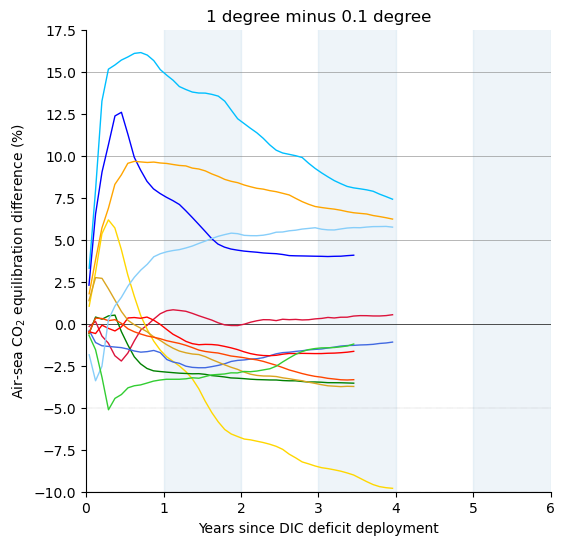

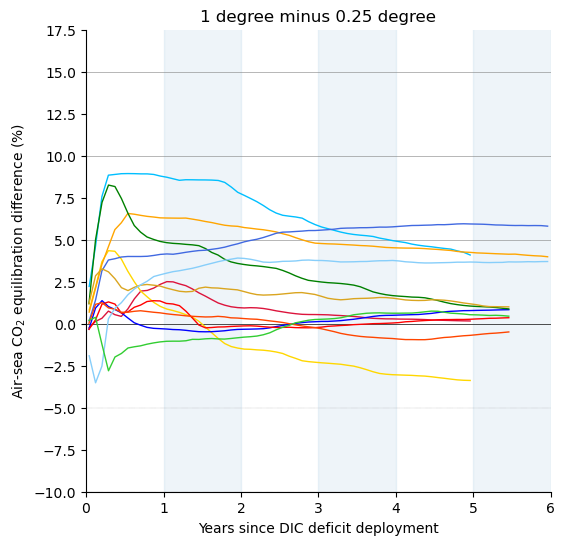

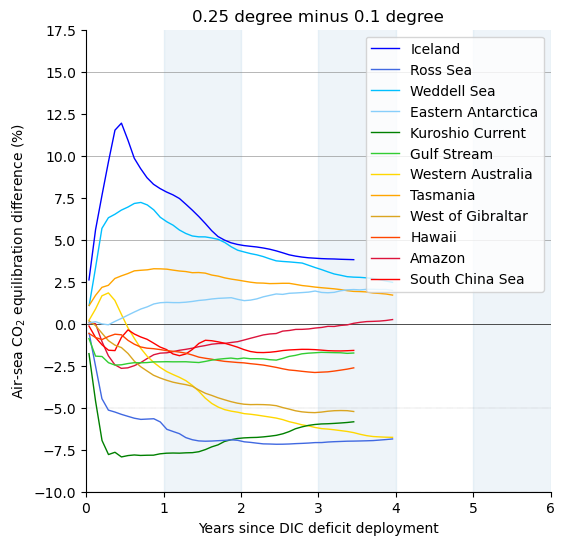

In [20]:
# Settings and flags
first_month_correction = True
SaveFlag = True
ymax  = 17.5
ymin  = -10

resolutions_1 = ['1', '1', '0.25']
resolutions_2 = ['0.1', '0.25', '0.1']

for idx, (res_1, res_2) in enumerate(zip(resolutions_1, resolutions_2)):
    plt.figure(figsize=(6, 6))
    # Go through each site and generate a separate curve
    for site in Results_3Res_All_sites:
        RunNo = str("{:02}".format(int(site)))
        
        # get original data
        original_data_1 = Results_3Res_All_sites[site][res_1]['original_data']
        original_data_1[' Model time'] = pd.to_datetime(original_data_1[' Model time'])
        original_data_2 = Results_3Res_All_sites[site][res_2]['original_data']
        original_data_2[' Model time'] = pd.to_datetime(original_data_2[' Model time'])

        # Set the time mask
        if exp_hemi[RunNo] == 'S':
            mask1 = (original_data_1[' Model time'] >= '2004-01-01')
            mask2 = (original_data_2[' Model time'] >= '2004-01-01')
        elif exp_hemi[RunNo] == 'N':
            mask1 = (original_data_1[' Model time'] >= '2004-07-01')
            mask2 = (original_data_2[' Model time'] >= '2004-07-01')


        # Calculate the percentage of DIC deficit
        deficit_in_percentage_1 = 100 - original_data_1[' DIC deficit'][mask1] * 100 / 2.5e14
        if first_month_correction:
            deficit_in_percentage_1.values[0] = 100 - original_data_1[' DIC deficit'][mask1].values[0] * 100 / (2.5e14 / 2)

        if res_2 != '0.1':
            deficit_in_percentage_2 = 100 - original_data_2[' DIC deficit'][mask2] * 100 / 2.5e14
            if first_month_correction:
                deficit_in_percentage_2.values[0] = 100 - original_data_2[' DIC deficit'][mask2].values[0] * 100 / (2.5e14 / 2)
        elif res_2 == '0.1':
            deficit_in_percentage_2 = 100 - original_data_2[' DIC deficit'][mask2] * 100 / (Real_DIC_dict[int(site)])
            if first_month_correction:
                deficit_in_percentage_2.values[0] = 100 -  original_data_2[' DIC deficit'][mask2].values[0] * 100 / ((Real_DIC_dict[int(site)]/2))

        length = min(len(deficit_in_percentage_1.values),len(deficit_in_percentage_2.values))
        if res_1 == '0.1' or res_2 == '0.1':
            time_series = original_data_1[' Model time'][mask1][:length]
            # Set checking date
            cutoff_date = pd.Timestamp('2008-01-01')
            # Find all indexes whose time is before cutoff_date
            valid_dates = time_series[time_series < cutoff_date]
            # Updated length to the number of days before 2008-01-01
            length = len(valid_dates)
        deficit_in_percentage_difference = deficit_in_percentage_1.values[:length] - deficit_in_percentage_2.values[:length]
        
        # Plotting difference timeseries for each site
        if exp_hemi[RunNo] == 'S':
            plt.plot(original_data_1[' Model time'][mask1][:length], deficit_in_percentage_difference, label=exp_name_1[int(site)], linewidth=1,c=site_color[exp_name_1[int(site)]],zorder=20)
        elif exp_hemi[RunNo] == 'N':
            plt.plot(original_data_1[' Model time'][mask1][:length]-pd.Timedelta(days=183), deficit_in_percentage_difference, label=exp_name_1[int(site)], linewidth=1,c=site_color[exp_name_1[int(site)]],zorder=20)
    
    # Set the title and label
    plt.title(f'{res_1} degree minus {res_2} degree')

    for year in np.arange(2005,2019,2):
        plt.fill_between([dt.datetime(year, 1, 1),dt.datetime(year+1, 1, 1)], [-100,-100],[100,100], alpha=0.075,zorder=0,color='C0')

    # Plot grid lines
    for y in np.arange(-40,0,5):
        plt.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.3)
    for y in np.arange(0,40,5):
        plt.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)
    plt.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[0,0],linestyle='-',c='k',zorder=2,linewidth=0.4)
    
    ax = plt.gca()  # Get the current Axes instance
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.ylabel('Air-sea CO$_{2}$ equilibration difference (%)')
    plt.xlabel('Years since DIC deficit deployment')
    
    plt.xticks(pd.date_range('2004-01-01', '2010-07-30', freq='AS-JAN'),labels=[f'{i}' for i in range(0, 7)])
    plt.yticks(np.arange(-50,50,2.5))
    
    plt.xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2010-01-01'))
    plt.ylim(ymin,ymax)


    # Plot legend
    if idx in [2]:
        plt.legend()
        sites_ordered_labels=['Iceland','Ross Sea','Weddell Sea','Eastern Antarctica',
                              'Kuroshio Current','Gulf Stream',
                              'Western Australia','Tasmania','West of Gibraltar',
                              'Hawaii','Amazon','South China Sea']
        handles, labels = ax.get_legend_handles_labels()
        sites_ordered_labels = [i for i in sites_ordered_labels  if i in labels]
        ordered_handles = [handles[labels.index(label)] for label in sites_ordered_labels]
        ordered_labels = [label for label in sites_ordered_labels]
        legend = plt.legend(ordered_handles, ordered_labels, loc='upper right')
        legend.set_zorder(25) 

    if SaveFlag:
        plt.savefig(f'{local_dir}/Figure2/{res_1}_deg_minus_{res_2}_deg.png', dpi=300)
    
    plt.show()

## Figure 5: air-sea CO2 equilibration  difference: 1 vs Zhou et al. (2024)

ZhouTyka2024  Amazon
ZhouTyka2024  Western Australia
ZhouTyka2024  Weddell Sea
ZhouTyka2024  Iceland
ZhouTyka2024  Tasmania
ZhouTyka2024  Kuroshio Current
ZhouTyka2024  Ross Sea
ZhouTyka2024  South China Sea
ZhouTyka2024  West of Gibraltar
ZhouTyka2024  Hawaii
ZhouTyka2024  Eastern Antarctica
ZhouTyka2024  Gulf Stream


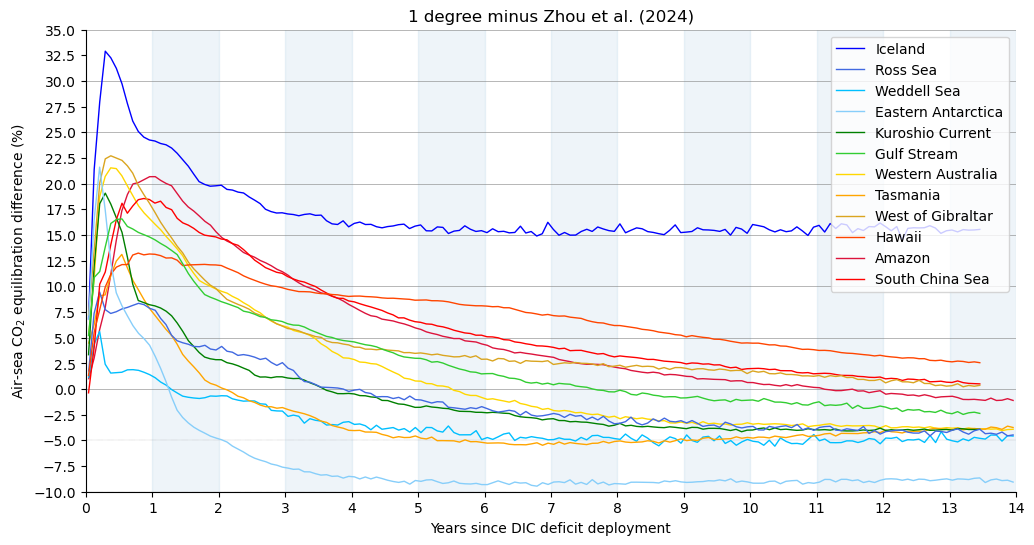

In [21]:
# Settings and flags
first_month_correction = True
ymax  = 35
ymin  = -10

title = '1 degree minus Zhou et al. (2024)'

plt.figure(figsize=(12, 6))
for site in Results_3Res_All_sites:
    RunNo = str("{:02}".format(int(site)))
    # get original data
    original_data_1 = Results_3Res_All_sites[site]['1']['original_data']
    original_data_1[' Model time'] = pd.to_datetime(original_data_1[' Model time'])

    # Set the time mask
    if exp_hemi[RunNo] == 'S':
        mask1 = (original_data_1[' Model time'] >= '2004-01-01')
    elif exp_hemi[RunNo] == 'N':
        mask1 = (original_data_1[' Model time'] >= '2004-07-01')


    # Calculate the percentage of DIC deficit
    deficit_in_percentage_1 = 100 - original_data_1[' DIC deficit'][mask1] * 100 / 2.5e14
    if first_month_correction:
        deficit_in_percentage_1.values[0] = 100 - original_data_1[' DIC deficit'][mask1].values[0] * 100 / (2.5e14 / 2)

    print('ZhouTyka2024 ',exp_name[RunNo])
    region_dic = {0:'Pacific',1:'Atlantic',2:'South',3:'Southern_Ocean'}
    season_dic = {0:'January',1:'April',2:'July',3:'October'}
    
    df = summarize[summarize['name'] == exp_name[RunNo]]

    curves=[]
    curves_all = []
    for index, row in df.iterrows():
        data = oae_eff_curves_global.OAE_efficiency.sel(region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season])*100*row['contribution']/row['eta_max']
        data_all = oae_eff_curves_global.OAE_efficiency.sel(region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season])*100/row['eta_max']
        # Use adjust_year function to adjust the time
        new_times = [adjust_year(time) for time in data['time'].values]
        # Convert new_times to pandas.DatetimeIndex
        new_times = pd.to_datetime([pd.Timestamp(time.isoformat()) for time in new_times])
        
        # Update the DataArray's 'time' coordinates
        data = data.assign_coords(time=new_times)
        data_all = data_all.assign_coords(time=new_times)
        curves_all.append(data_all)
        curves.append(data)
    curves_sum = sum(curves)
    if exp_hemi[RunNo] == 'N':
        curves_sum = curves_sum[6:]
    length = min(len(curves_sum),len(deficit_in_percentage_1.values))
    if exp_hemi[RunNo] == 'S':
        plt.plot(curves_sum[:length].time, deficit_in_percentage_1.values[:length] - curves_sum[:length].values,label=exp_name_1[int(site)], linewidth=1,c=site_color[exp_name_1[int(site)]],zorder=20)
    elif exp_hemi[RunNo] == 'N':
        plt.plot(curves_sum[:length].time-pd.Timedelta(days=183), deficit_in_percentage_1.values[:length] - curves_sum[:length].values,label=exp_name_1[int(site)], linewidth=1,c=site_color[exp_name_1[int(site)]],zorder=20)
       

# Set the title and label
plt.title(title)


# Plot grid lines
for year in np.arange(2005,2019,2):
    plt.fill_between([dt.datetime(year, 1, 1),dt.datetime(year+1, 1, 1)], [-100,-100],[100,100], alpha=0.075,zorder=0,color='C0')
for y in np.arange(-40,0,5):
    plt.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.3)
for y in np.arange(0,40,5):
    plt.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)
    

ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('Air-sea CO$_{2}$ equilibration difference (%)')
plt.xlabel('Years since DIC deficit deployment')

plt.xticks(pd.date_range('2004-01-01', '2018-07-30', freq='AS-JAN'),labels=[f'{i}' for i in range(0, 15)])
plt.yticks(np.arange(-50,50,2.5))

plt.xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2018-01-01'))
plt.ylim(ymin,ymax)


# Plot legend
plt.legend()
sites_ordered_labels=['Iceland','Ross Sea','Weddell Sea','Eastern Antarctica',
                      'Kuroshio Current','Gulf Stream',
                      'Western Australia','Tasmania','West of Gibraltar',
                      'Hawaii','Amazon','South China Sea']
handles, labels = ax.get_legend_handles_labels()
sites_ordered_labels = [i for i in sites_ordered_labels  if i in labels]
ordered_handles = [handles[labels.index(label)] for label in sites_ordered_labels]
ordered_labels = [label for label in sites_ordered_labels]
legend = plt.legend(ordered_handles, ordered_labels, loc='upper right')
legend.set_zorder(25) 

if SaveFlag:
    plt.savefig(f'{local_dir}/Figure2/1_deg_minus_Zhou_etal_2024.png', dpi=300)
plt.show()

## Figure 5: air-sea CO2 equilibration  difference: 1 vs Bach et al. (2023) and He and Tyka (2023)

BachETAL2023  Amazon
index: 5
index: 6
index: 7
index: 8
Zhou et al. (2024) mean site eta_max:  0.7918343708347801
HeTyka2023  Amazon
BachETAL2023  Iceland
index: 9
index: 10
index: 11
Zhou et al. (2024) mean site eta_max:  0.8584666456952863
HeTyka2023  Iceland
BachETAL2023  Hawaii
index: 2
index: 3
index: 4
Zhou et al. (2024) mean site eta_max:  0.8078629195631293
HeTyka2023  Hawaii
index: 35
index: 36
index: 37
Zhou et al. (2024) mean site eta_max:  0.8426677370075748
HeTyka2023  Tasmania
index: 38
index: 39
Zhou et al. (2024) mean site eta_max:  0.8231670207413084
HeTyka2023  Kuroshio Current
index: 40
index: 41
Zhou et al. (2024) mean site eta_max:  0.8178320036494855
HeTyka2023  West of Gibraltar


/jobfs/131636325.gadi-pbs/ipykernel_3544599/73286350.py:52: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected
/jobfs/131636325.gadi-pbs/ipykernel_3544599/73286350.py:52: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected
/jobfs/131636325.gadi-pbs/ipykernel_3544599/73286350.py:52: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # T

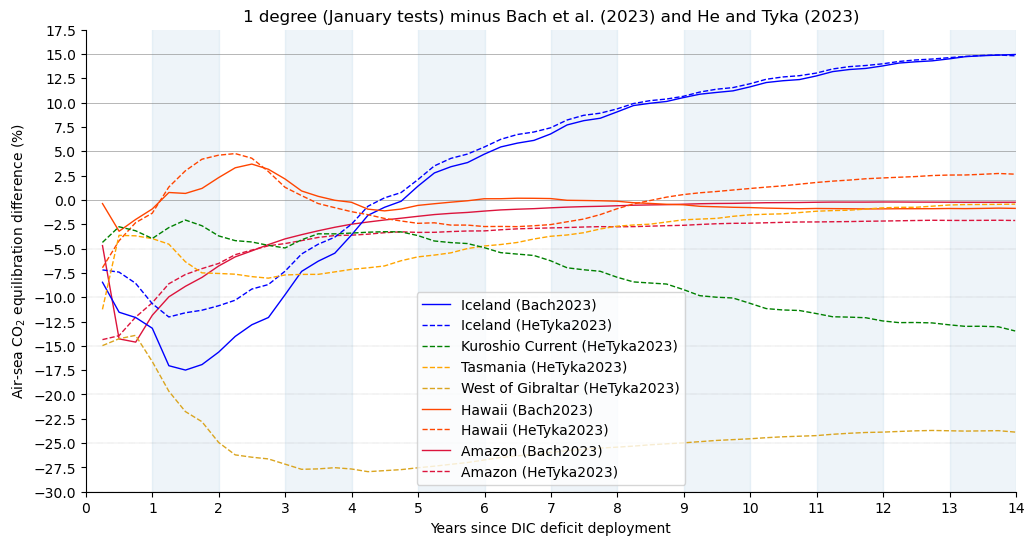

In [27]:
# Settings and flags
first_month_correction = True
ymax  = 17.5
ymin  = -30

title = '1 degree (January tests) minus Bach et al. (2023) and He and Tyka (2023)'

plt.figure(figsize=(12, 6))
for site in ['4','5','3','16','17','18']:
    
    if site in ['4','5','3']:
        RunNo = str("{:02}".format(int(site)))
        print('BachETAL2023 ',exp_name[RunNo])
        curve = BachETAL2023[exp_name[RunNo]]['curve']*100
        curve[0] = 0 # This is maunally correction

        # get original data
        if exp_name[RunNo] in ['Iceland','Hawaii']:
            original_data_Jan = Results_3Res_All_sites_2004_01_H_I_K_E[site]['1']['original_data']
        elif exp_name[RunNo] in ['Amazon']:
            original_data_Jan = Results_3Res_All_sites[site]['1']['original_data']
        original_data_Jan[' Model time'] = pd.to_datetime(original_data_Jan[' Model time'])
        # 设置时间掩码
        mask1 = (original_data_Jan[' Model time'] >= '2004-01-01')
        # 计算 DIC deficit 的百分比
        deficit_in_percentage_Jan = 100 - original_data_Jan[' DIC deficit'][mask1] * 100 / 2.5e14
        if first_month_correction:
            deficit_in_percentage_Jan.values[0] = 100 - original_data_Jan[' DIC deficit'][mask1].values[0] * 100 / (2.5e14 / 2)

        # Bach et al., 2023 data is in seaasonal mean format so thet we do the similar processes for ACCESS monthly mean data.
        access_tar = deficit_in_percentage_Jan.values[2:]
        averaged_array = np.array([np.mean(access_tar[i:i+3]) for i in range(0, len(access_tar), 3)])

        plt.plot(BachETAL2023[exp_name[RunNo]]['time'][1:len(deficit_in_percentage_Jan.values[3::3])+2],averaged_array- curve[1:len(deficit_in_percentage_Jan.values[3::3])+2],
                label=exp_name_1[int(site)]+' (Bach2023)', linewidth=1,c=site_color[exp_name_1[int(site)]],linestyle='-',zorder=20)
    
    if site in ['4','5','3','16','17','18']:
        RunNo = str("{:02}".format(int(site)))
        # Load corresponding eta_max from Zhou et al. (2024) results
        df = summarize[summarize['name'] == exp_name[RunNo]]
        mean_site_eta_max = 0
        for index, row in df.iterrows():
            print('index:',index)
            mean_site_eta_max += row['contribution']* row['eta_max']
        print('Zhou et al. (2024) mean site eta_max: ',mean_site_eta_max)

        Site_transition = {'Amazon':'brazil','Iceland':'island','Tasmania':'tasmania','Hawaii':'hawaii', 'Kuroshio Current':'japan', 'West of Gibraltar':'portugal'}        
        print('HeTyka2023 ', exp_name[RunNo])
        eta_max = np.max([mean_site_eta_max,np.nanmax(HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'])])
        curve = HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'] /mean_site_eta_max * 100
        time =  HeTyka.loc[Site_transition[exp_name[RunNo]]]['time']
        curve[0] = 0  # This is manually corrected

        # get original data
        if exp_name[RunNo] in ['Iceland','Hawaii','Kuroshio Current','West of Gibraltar']:
            original_data_Jan = Results_3Res_All_sites_2004_01_H_I_K_E[site]['1']['original_data']
        elif exp_name[RunNo] in ['Tasmania','Amazon']:
            original_data_Jan = Results_3Res_All_sites[site]['1']['original_data']
        else:
            raise ValueError(f"Invalid value in exp_name[RunNo] {e}")
        original_data_Jan[' Model time'] = pd.to_datetime(original_data_Jan[' Model time'])
        # 设置时间掩码
        mask1 = (original_data_Jan[' Model time'] >= '2004-01-01')
        # 计算 DIC deficit 的百分比
        deficit_in_percentage_Jan = 100 - original_data_Jan[' DIC deficit'][mask1] * 100 / 2.5e14
        if first_month_correction:
            deficit_in_percentage_Jan.values[0] = 100 - original_data_Jan[' DIC deficit'][mask1].values[0] * 100 / (2.5e14 / 2)

        # Bach et al., 2023 data is in seaasonal mean format so thet we do the similar processes for ACCESS monthly mean data.
        access_tar = deficit_in_percentage_Jan.values[2:]
        averaged_array = np.array([np.mean(access_tar[i:i+3]) for i in range(0, len(access_tar), 3)])

        plot_time_HeTyka = time[1:len(deficit_in_percentage_Jan.values[3::3])+2].values
        plot_time_HeTyka = [pd.Timestamp("2004-01-01") + pd.DateOffset(days=year * 365) for year in plot_time_HeTyka]
        plt.plot(plot_time_HeTyka,
                 averaged_array- curve[1:len(deficit_in_percentage_Jan.values[3::3])+2],
                label=exp_name_1[int(site)]+' (HeTyka2023)', linewidth=1,c=site_color[exp_name_1[int(site)]],linestyle='--',zorder=20)

# Set the title and label
plt.title(title)


# Plot grid lines
for year in np.arange(2005,2019,2):
    plt.fill_between([dt.datetime(year, 1, 1),dt.datetime(year+1, 1, 1)], [-100,-100],[100,100], alpha=0.075,zorder=0,color='C0')
for y in np.arange(-40,0,5):
    plt.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.3)
for y in np.arange(0,40,5):
    plt.plot([pd.to_datetime('2004-01-01'), pd.to_datetime('2019-12-31')],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)
    

ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylabel('Air-sea CO$_{2}$ equilibration difference (%)')
plt.xlabel('Years since DIC deficit deployment')

plt.xticks(pd.date_range('2004-01-01', '2018-07-30', freq='AS-JAN'),labels=[f'{i}' for i in range(0, 15)])
plt.yticks(np.arange(-50,50,2.5))

plt.xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2018-01-01'))
plt.ylim(ymin,ymax)


# Plot legend
plt.legend()
sites_ordered_labels=['Iceland (Bach2023)','Iceland (HeTyka2023)',
                      'Kuroshio Current (HeTyka2023)',
                      'Tasmania (HeTyka2023)',
                      'West of Gibraltar (HeTyka2023)',
                      'Hawaii (Bach2023)','Hawaii (HeTyka2023)',
                      'Amazon (Bach2023)','Amazon (HeTyka2023)']
handles, labels = ax.get_legend_handles_labels()
sites_ordered_labels = [i for i in sites_ordered_labels  if i in labels]
ordered_handles = [handles[labels.index(label)] for label in sites_ordered_labels]
ordered_labels = [label for label in sites_ordered_labels]
legend = plt.legend(ordered_handles, ordered_labels, loc='lower center')
legend.set_zorder(25) 
if SaveFlag:
    plt.savefig(f'{local_dir}/Figure2/1_deg_minus_BachETAL2023_HeTyka2023.png', dpi=300)
plt.show()

# inter-resolution and inter-model comparsions for 4 categories

## Making dictionary for storing all inter-resolution and inter-model comparsions for each site

In [9]:
#Settings and flags
first_month_correction = True
ZhouTyka2024 = True
use_BachETAL2023 = True
HeTyka2023 = True

# Creating dictionary for storing group categorized comparsion results
resolutions_1 = ['1', '1', '0.25']
resolutions_2 = ['0.1', '0.25', '0.1']
comparsion_names = ['1 degree minus 0.1 degree','1 degree minus 0.25 degree',
                    '0.25 degree minus 0.1 degree',
                    '1 degree minus Zhou et al. (2024)','1 degree minus Bach et al. (2023)','1 degree minus He and Tyka (2023)']

# Generate category names and initialize collections
comparsion_cate_names = [f"{cate}:{name}" for cate in 
                         ['Tropics', 'Boundary currents', 'Mid-latitudes', 'Polar regions'] for name in comparsion_names]
collection = {name: {} for name in comparsion_names}
collection_cates = {name: {} for name in comparsion_cate_names}


# Go through each site, generate and store the timeseries
for site in Results_3Res_All_sites:
    RunNo = str("{:02}".format(int(site)))

    for idx, (res_1, res_2,comparsion_name) in enumerate(zip(resolutions_1, resolutions_2,comparsion_names[:3])):
        original_data_1 = Results_3Res_All_sites[site][res_1]['original_data']
        original_data_1[' Model time'] = pd.to_datetime(original_data_1[' Model time'])
        original_data_2 = Results_3Res_All_sites[site][res_2]['original_data']
        original_data_2[' Model time'] = pd.to_datetime(original_data_2[' Model time'])

        # Set the time mask
        if exp_hemi[RunNo] == 'S':
            mask1 = (original_data_1[' Model time'] >= '2004-01-01')
            mask2 = (original_data_2[' Model time'] >= '2004-01-01')
        elif exp_hemi[RunNo] == 'N':
            mask1 = (original_data_1[' Model time'] >= '2004-07-01')
            mask2 = (original_data_2[' Model time'] >= '2004-07-01')

        # Calculate the percentage of DIC deficit
        deficit_in_percentage_1 = 100 - original_data_1[' DIC deficit'][mask1] * 100 / 2.5e14
        if first_month_correction:
            deficit_in_percentage_1.values[0] = 100 - original_data_1[' DIC deficit'][mask1].values[0] * 100 / (2.5e14 / 2)
        
        deficit_in_percentage_2 = 100 - original_data_2[' DIC deficit'][mask2] * 100 / 2.5e14
        if first_month_correction:
            deficit_in_percentage_2.values[0] = 100 - original_data_2[' DIC deficit'][mask2].values[0] * 100 / (2.5e14 / 2)

        # Calculate the difference
        length = min(len(deficit_in_percentage_1.values),len(deficit_in_percentage_2.values))
        if res_1 == '0.1' or res_2 == '0.1':
            time_series = original_data_1[' Model time'][mask1][:length]
            # Set cut off date
            cutoff_date = pd.Timestamp('2008-01-01')
            # Find all indexes whose time is before cutoff_date
            valid_dates = time_series[time_series < cutoff_date]
            # Updated length to the number of days before cut off date
            length = len(valid_dates)
        deficit_in_percentage_difference = deficit_in_percentage_1.values[:length] - deficit_in_percentage_2.values[:length]
        collection[comparsion_name][site] = deficit_in_percentage_difference

    # Extract the 1 degree original data for following inter-mdoel comparsions
    original_data_1 = Results_3Res_All_sites[site]['1']['original_data']
    original_data_1[' Model time'] = pd.to_datetime(original_data_1[' Model time'])
    # Set the time mask
    if exp_hemi[RunNo] == 'S':
        mask1 = (original_data_1[' Model time'] >= '2004-01-01')
    elif exp_hemi[RunNo] == 'N':
        mask1 = (original_data_1[' Model time'] >= '2004-07-01')
    # Calculate the percentage of DIC deficit
    deficit_in_percentage_1 = 100 - original_data_1[' DIC deficit'][mask1] * 100 / 2.5e14
    if first_month_correction:
        deficit_in_percentage_1.values[0] = 100 - original_data_1[' DIC deficit'][mask1].values[0] * 100 / (2.5e14 / 2)
    
    if exp_name[RunNo] in ['Iceland','Hawaii','Kuroshio Current','West of Gibraltar']:
        original_data_Jan = Results_3Res_All_sites_2004_01_H_I_K_E[site]['1']['original_data']
        original_data_Jan[' Model time'] = pd.to_datetime(original_data_Jan[' Model time'])
        # Set the time mask
        mask1 = (original_data_Jan[' Model time'] >= '2004-01-01')
        # Calculate the percentage of DIC deficit
        deficit_in_percentage_Jan = 100 - original_data_Jan[' DIC deficit'][mask1] * 100 / 2.5e14
        if first_month_correction:
            deficit_in_percentage_Jan.values[0] = 100 - original_data_Jan[' DIC deficit'][mask1].values[0] * 100 / (2.5e14 / 2)

    if ZhouTyka2024:
        print('ZhouTyka2024 ',exp_name[RunNo])
        region_dic = {0:'Pacific',1:'Atlantic',2:'South',3:'Southern_Ocean'}
        season_dic = {0:'January',1:'April',2:'July',3:'October'}
        
        df = summarize[summarize['name'] == exp_name[RunNo]]

        curves=[]
        curves_all = []
        for index, row in df.iterrows():
            data = oae_eff_curves_global.OAE_efficiency.sel(region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season])*100*row['contribution']/row['eta_max']
            data_all = oae_eff_curves_global.OAE_efficiency.sel(region=region_dic[row.region], polygon=row.polygon, season=season_dic[row.season])*100/row['eta_max']
            # Use adjust_year function to adjust the time
            new_times = [adjust_year(time) for time in data['time'].values]
            # Convert new_times to pandas.DatetimeIndex
            new_times = pd.to_datetime([pd.Timestamp(time.isoformat()) for time in new_times])
            # Update the DataArray's 'time' coordinates
            data = data.assign_coords(time=new_times)
            data_all = data_all.assign_coords(time=new_times)
            curves_all.append(data_all)
            curves.append(data)
        curves_sum = sum(curves)
        if exp_hemi[RunNo] == 'N':
            curves_sum = curves_sum[6:]
        length = min(len(curves_sum),len(deficit_in_percentage_1.values))
        collection['1 degree minus Zhou et al. (2024)'][site] = deficit_in_percentage_1.values[:length] - curves_sum[:length].values
            
    if use_BachETAL2023 and exp_name[RunNo] in ['Amazon','Iceland','Hawaii']:
        print('BachETAL2023 ',exp_name[RunNo])
        curve = BachETAL2023[exp_name[RunNo]]['curve']*100
        curve[0] = 0 # This is maunally correction
        if exp_name[RunNo] in ['Amazon']:
            # Bach et al., 2023 data is in seaasonal mean format so thet we do the similar processes for ACCESS monthly mean data.
            access_tar = deficit_in_percentage_1.values[2:]
            averaged_array = np.array([np.mean(access_tar[i:i+3]) for i in range(0, len(access_tar), 3)])
        elif exp_name[RunNo] in ['Iceland','Hawaii']:
            # Bach et al., 2023 data is in seaasonal mean format so thet we do the similar processes for ACCESS monthly mean data.
            access_tar = deficit_in_percentage_Jan.values[2:]
            averaged_array = np.array([np.mean(access_tar[i:i+3]) for i in range(0, len(access_tar), 3)])
        collection['1 degree minus Bach et al. (2023)'][site] = averaged_array - curve[1:][:len(averaged_array)]

    if HeTyka2023 and exp_name[RunNo] in ['Amazon','Iceland','Tasmania','Hawaii', 'Kuroshio Current', 'West of Gibraltar']:
        print('HeTyka2023 ', exp_name[RunNo])
        # Load corresponding eta_max from Zhou et al. (2024) results
        df = summarize[summarize['name'] == exp_name[RunNo]]
        mean_site_eta_max = 0
        for index, row in df.iterrows():
            mean_site_eta_max += row['contribution']* row['eta_max']
        print('Referencing Zhou et al. (2024) mean site eta_max: ',mean_site_eta_max)

        Site_transition = {'Amazon':'brazil','Iceland':'island','Tasmania':'tasmania','Hawaii':'hawaii', 'Kuroshio Current':'japan', 
                           'West of Gibraltar':'portugal'}        
        
        eta_max = np.max([mean_site_eta_max,np.nanmax(HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'])])
        curve = HeTyka.loc[Site_transition[exp_name[RunNo]]]['eta'] /mean_site_eta_max * 100
        time =  HeTyka.loc[Site_transition[exp_name[RunNo]]]['time']
        curve[0] = 0  # This is manually corrected

        # get original data
        if exp_name[RunNo] in ['Iceland','Hawaii','Kuroshio Current','West of Gibraltar']:
            deficit_in_percentage_HeTyka2023 = deficit_in_percentage_Jan
        elif exp_name[RunNo] in ['Tasmania','Amazon']:
            deficit_in_percentage_HeTyka2023 = deficit_in_percentage_1
        # Bach et al., 2023 data is in seaasonal mean format so thet we do the similar processes for ACCESS monthly mean data.
        access_tar = deficit_in_percentage_HeTyka2023.values[2:]
        averaged_array = np.array([np.mean(access_tar[i:i+3]) for i in range(0, len(access_tar), 3)])
        collection['1 degree minus He and Tyka (2023)'][site] = averaged_array - curve[1:][:len(averaged_array)].values

ZhouTyka2024  Amazon
BachETAL2023  Amazon
HeTyka2023  Amazon
Referencing Zhou et al. (2024) mean site eta_max:  0.7918343708347801
ZhouTyka2024  Western Australia
ZhouTyka2024  Weddell Sea
ZhouTyka2024  Iceland
BachETAL2023  Iceland
HeTyka2023  Iceland
Referencing Zhou et al. (2024) mean site eta_max:  0.8584666456952863
ZhouTyka2024  Tasmania
HeTyka2023  Tasmania
Referencing Zhou et al. (2024) mean site eta_max:  0.8426677370075748
ZhouTyka2024  Kuroshio Current
HeTyka2023  Kuroshio Current
Referencing Zhou et al. (2024) mean site eta_max:  0.8231670207413084
ZhouTyka2024  Ross Sea
ZhouTyka2024  South China Sea


/jobfs/131636325.gadi-pbs/ipykernel_3551712/1347379374.py:140: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected
/jobfs/131636325.gadi-pbs/ipykernel_3551712/1347379374.py:140: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected
/jobfs/131636325.gadi-pbs/ipykernel_3551712/1347379374.py:140: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0]

ZhouTyka2024  West of Gibraltar
HeTyka2023  West of Gibraltar
Referencing Zhou et al. (2024) mean site eta_max:  0.8178320036494855
ZhouTyka2024  Hawaii
BachETAL2023  Hawaii
HeTyka2023  Hawaii
Referencing Zhou et al. (2024) mean site eta_max:  0.8078629195631293
ZhouTyka2024  Eastern Antarctica
ZhouTyka2024  Gulf Stream


/jobfs/131636325.gadi-pbs/ipykernel_3551712/1347379374.py:140: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  curve[0] = 0  # This is manually corrected


## Calculate the mean for comparisons in each category
### Summarize site data according to categories and comparison groups. Then, calculate mean, absolute and corresponding std for each catrgory

In [10]:
comparsion_result = {}
comparsion_collection = {}

# Go through each site and generate a separate curve
for cate,sites_here in zip(['Tropics','Boundary currents','Mid-latitudes','Polar regions'],
                           [['3','4','8'],['17','21'],['7','16','18'],['5','6','12','13']]):
    for site in sites_here:
        RunNo = str("{:02}".format(int(site)))
        for comparsion_name in comparsion_names:
            if comparsion_name == comparsion_names[4]:
                if exp_name[RunNo] in ['Amazon','Iceland','Hawaii']:
                    collection_cates[cate+':'+comparsion_name][site] = collection[comparsion_name][site]
            elif comparsion_name == comparsion_names[5]:
                if exp_name[RunNo] in ['Amazon','Iceland','Tasmania','Hawaii', 'Kuroshio Current', 'West of Gibraltar']:
                    collection_cates[cate+':'+comparsion_name][site] = collection[comparsion_name][site]
            else:
                collection_cates[cate+':'+comparsion_name][site] = collection[comparsion_name][site]

# Generate comparison collection and results
for collection_type in [collection_cates,collection]:
    for comparsion_name in collection_type:
        comparsion_collection[comparsion_name] = []
        comparsion_result[comparsion_name] = {}
        length = 0
    
        for site in collection_type[comparsion_name]:
            length = max(length, len(collection_type[comparsion_name][site]))
    
        for site in collection_type[comparsion_name]:
            tar = np.zeros(length)
            tar[:len(collection_type[comparsion_name][site])] = collection_type[comparsion_name][site]
            comparsion_collection[comparsion_name].append(tar)
    
        comparsion_result[comparsion_name]['mean'] = np.array(comparsion_collection[comparsion_name]).mean(axis=0)
        comparsion_result[comparsion_name]['abs_mean'] = np.absolute(np.array(comparsion_collection[comparsion_name])).mean(axis=0)
        comparsion_result[comparsion_name]['std'] = np.array(comparsion_collection[comparsion_name]).std(axis=0)
        comparsion_result[comparsion_name]['abs_std'] = np.absolute(np.array(comparsion_collection[comparsion_name])).std(axis=0)

### Figure 4: Plot the inter-resolution difference time series for Absolute Mean with Standard Deviation

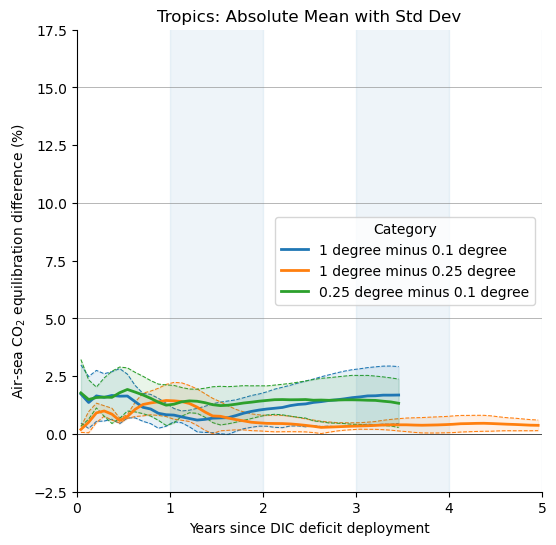

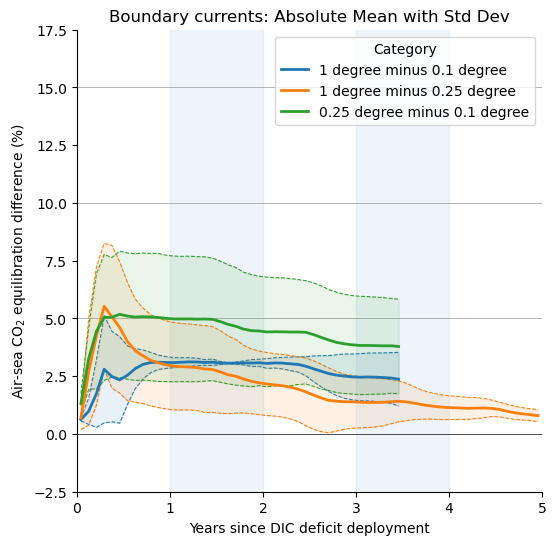

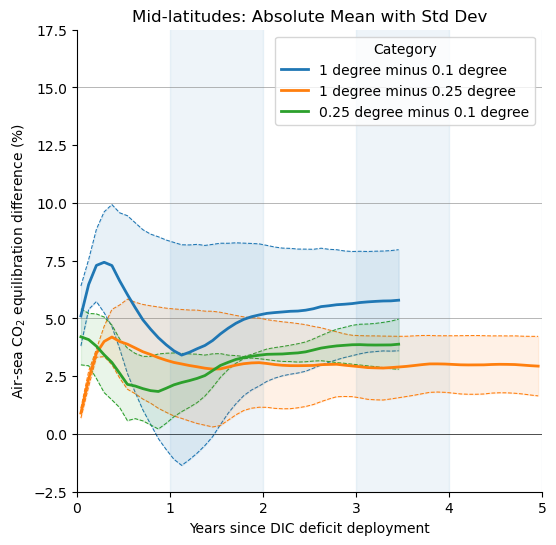

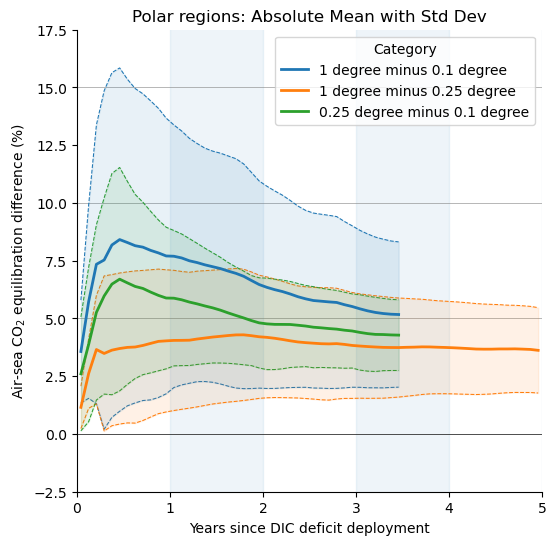

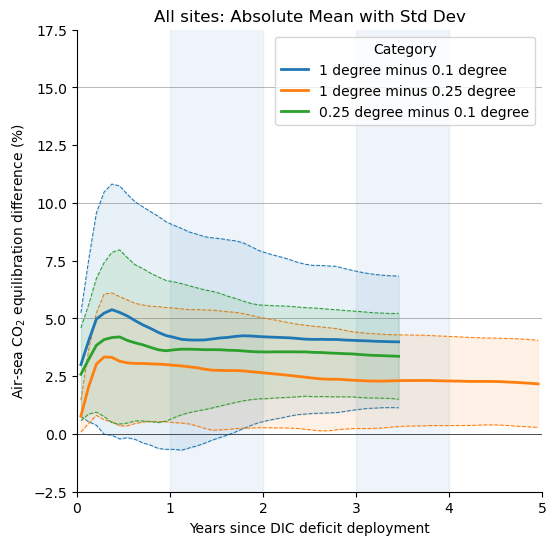

In [15]:
ylim_min = -2.5
ylim_max = 17.5
SaveFlag = True

for cate in ['Tropics','Boundary currents','Mid-latitudes','Polar regions','All sites']:
    plt.figure(figsize=(6,6))
    plt.title(f"{cate}: Absolute Mean with Std Dev")
    for idx, cate2 in enumerate(['1 degree minus 0.1 degree','1 degree minus 0.25 degree', '0.25 degree minus 0.1 degree']):

        name = cate2 if cate == 'All sites' else f"{cate}:{cate2}"

        length = len(comparsion_result[name]['abs_mean'])
        x_values = np.arange(length) / 12 + 0.5 / 12 if name != '1 degree minus Bach et al. (2023)' else np.arange(length) / 4 + 0.25
        # Assign time mask for different comparsions
        if '0.1' in name:
            mask = x_values<3.5
        elif '0.25' in name: 
            mask = x_values<5
        else:
             mask = x_values<13.5
        time         = x_values[mask]
        abs_mean     = comparsion_result[name]['abs_mean'][mask]
        abs_mean_std = comparsion_result[name]['abs_std'][mask]


        
        # Plot mean
        plt.plot(time, abs_mean, c=f'C{idx}', label=f"{cate2}",zorder=10,linewidth=2)
        plt.fill_between(time,abs_mean + abs_mean_std,abs_mean - abs_mean_std, alpha=0.10, color=f'C{idx}',zorder=9)
        plt.plot(time,abs_mean + abs_mean_std, c=f'C{idx}',linestyle='--',linewidth=0.75)
        plt.plot(time,abs_mean - abs_mean_std, c=f'C{idx}',linestyle='--',linewidth=0.75)
    
    plt.legend(title='Category')
    plt.ylabel('Air-sea CO$_{2}$ equilibration difference (%)')
    plt.xlabel('Years since DIC deficit deployment')


    for year in np.arange(1,14,2):
        plt.fill_between([year,year+1], [-100,-100],[100,100], alpha=0.075,zorder=0,color='C0')
    for y in np.arange(-40,0,5):
        plt.plot([0,14],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.3)
    for y in np.arange(0,40,5):
        plt.plot([0,14],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)
    
    plt.plot([0,14],[0,0],linestyle='-',c='k',zorder=2,linewidth=0.4)
    ax = plt.gca()  # Get the current axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
    plt.xlim(0, 5)
    x = plt.gca() 
    ax.set_yticks(np.arange(-25,25,2.5))

    plt.ylim(ylim_min,ylim_max)

    # Saving image
    if SaveFlag:
        plot_dir = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result'
        plt.savefig(f'{local_dir}/Figure2/Inter-Res_diff_Category_{cate}_Abs_Meanwith_Std_Dev.png', dpi=300)
        
    plt.show()

### Figure 5: Plot the inter-model difference time series for Absolute Mean with Standard Deviation

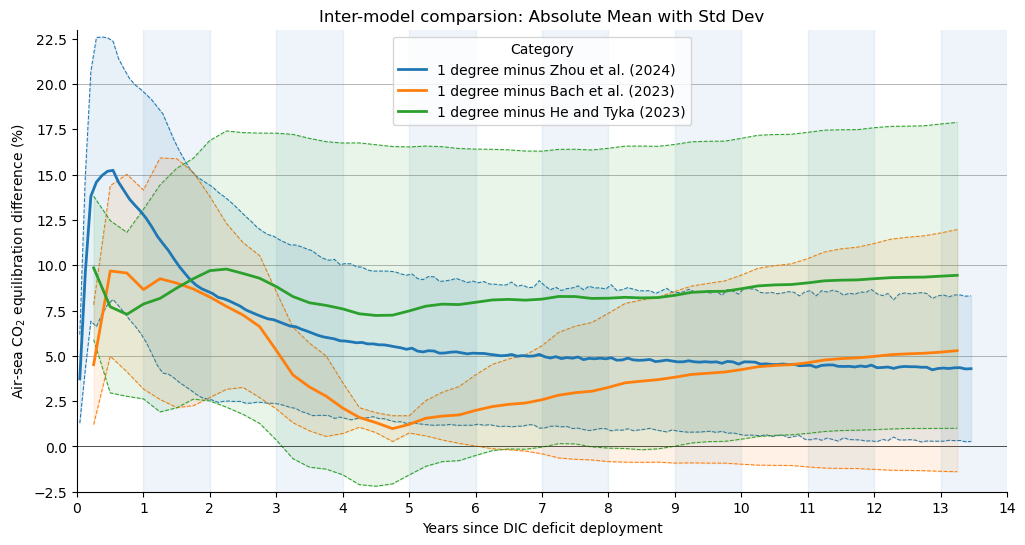

In [23]:
ylim_min = -2.5
ylim_max = 23
SaveFlag = True

plt.figure(figsize=(12,6))
plt.title(f"Inter-model comparsion: Absolute Mean with Std Dev")
for idx,(cate,name_short) in enumerate(zip(['1 degree minus Zhou et al. (2024)','1 degree minus Bach et al. (2023)','1 degree minus He and Tyka (2023)'],
                           ['ZhouETAL2024','BachETAL2023','HeTyka2023'])):
    


    name = cate
        

    length = len(comparsion_result[name]['abs_mean'])
    x_values = np.arange(length) / 12 + 0.5 / 12 if name not in ['1 degree minus Bach et al. (2023)','1 degree minus He and Tyka (2023)'] else np.arange(length) / 4 + 0.25
    # Assign time mask for different comparsions
    if '0.1' in name:
        mask = x_values<3.5
    elif '0.25' in name: 
        mask = x_values<5
    else:
         mask = x_values<13.5
    time         = x_values[mask]
    abs_mean     = comparsion_result[name]['abs_mean'][mask]
    abs_mean_std = comparsion_result[name]['abs_std'][mask]


    
    # Plot mean
    plt.plot(time, abs_mean, c=f'C{idx}', label=f"{cate}",zorder=10,linewidth=2)
    plt.fill_between(time,abs_mean + abs_mean_std,abs_mean - abs_mean_std, alpha=0.10, color=f'C{idx}',zorder=9)
    plt.plot(time,abs_mean + abs_mean_std, c=f'C{idx}',linestyle='--',linewidth=0.75)
    plt.plot(time,abs_mean - abs_mean_std, c=f'C{idx}',linestyle='--',linewidth=0.75)
    
plt.legend(title='Category')
plt.ylabel('Air-sea CO$_{2}$ equilibration difference (%)')
plt.xlabel('Years since DIC deficit deployment')


for year in np.arange(1,14,2):
    plt.fill_between([year,year+1], [-100,-100],[100,100], alpha=0.075,zorder=0,color='C0')
for y in np.arange(-40,0,5):
    plt.plot([0,14],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.3)
for y in np.arange(0,40,5):
    plt.plot([0,14],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)

plt.plot([0,14],[0,0],linestyle='-',c='k',zorder=2,linewidth=0.4)
ax = plt.gca()  # Get the current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.xlim(0, 13.5)
ax.set_yticks(np.arange(-25,30,2.5))
ax.set_xticks(np.arange(0,15))

plt.ylim(ylim_min,ylim_max)

# Saving image
if SaveFlag:
    plot_dir = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result'
    plt.savefig(f'{local_dir}/Figure2/Inter-Model_diff_3_models_Abs_Meanwith_Std_Dev.png', dpi=300)
    
plt.show()

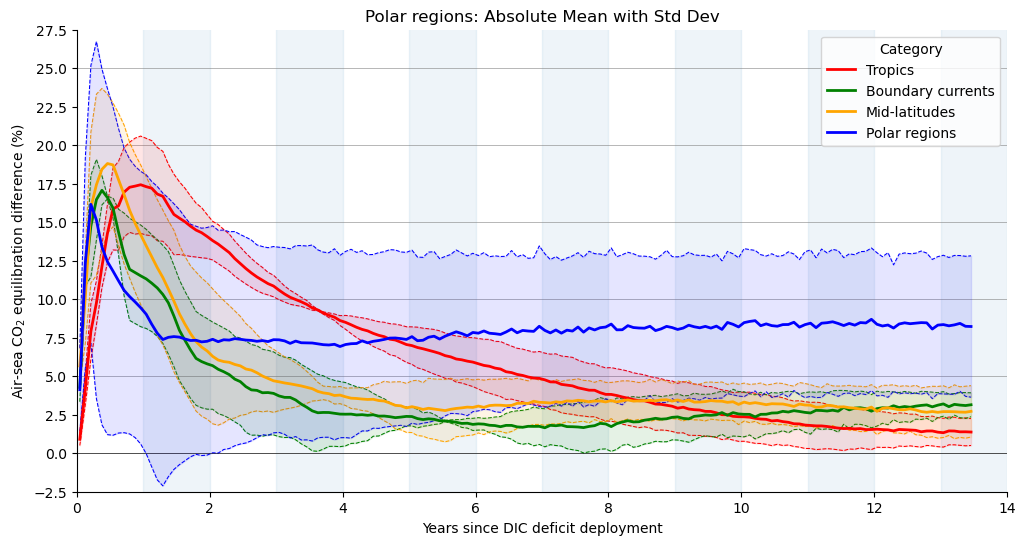

In [29]:
ylim_min = -2.5
ylim_max = 27.5
SaveFlag = True

cate_colors = {'Tropics':'r','Boundary currents':'g','Mid-latitudes':'orange','Polar regions':'b'}
plt.figure(figsize=(12,6))
plt.title(f"{cate}: Absolute Mean with Std Dev")
for cate in ['Tropics','Boundary currents','Mid-latitudes','Polar regions']:
    
    for idx, cate2 in enumerate(['1 degree minus Zhou et al. (2024)']):

        name = f"{cate}:{cate2}"

        length = len(comparsion_result[name]['abs_mean'])
        x_values = np.arange(length) / 12 + 0.5 / 12
        # Assign time mask
        mask = x_values<13.5
        time         = x_values[mask]
        abs_mean     = comparsion_result[name]['abs_mean'][mask]
        abs_mean_std = comparsion_result[name]['abs_std'][mask]


        
        # Plot mean
        plt.plot(time, abs_mean, c=cate_colors[cate], label=f"{cate}",zorder=10,linewidth=2)
        plt.fill_between(time,abs_mean + abs_mean_std,abs_mean - abs_mean_std, alpha=0.10, color=cate_colors[cate],zorder=9)
        plt.plot(time,abs_mean + abs_mean_std, c=cate_colors[cate],linestyle='--',linewidth=0.75)
        plt.plot(time,abs_mean - abs_mean_std, c=cate_colors[cate],linestyle='--',linewidth=0.75)
    
plt.legend(title='Category')
plt.ylabel('Air-sea CO$_{2}$ equilibration difference (%)')
plt.xlabel('Years since DIC deficit deployment')


for year in np.arange(1,14,2):
    plt.fill_between([year,year+1], [-100,-100],[100,100], alpha=0.075,zorder=0,color='C0')
for y in np.arange(-40,0,5):
    plt.plot([0,14],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.3)
for y in np.arange(0,40,5):
    plt.plot([0,14],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.4)

plt.plot([0,14],[0,0],linestyle='-',c='k',zorder=2,linewidth=0.4)
ax = plt.gca()  # Get the current axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.xlim(0, 14)
x = plt.gca() 
ax.set_yticks(np.arange(-25,30,2.5))

plt.ylim(ylim_min,ylim_max)

# Saving image
if SaveFlag:
    plot_dir = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result'
    plt.savefig(f'{local_dir}/Figure2/Model_diff_ZhouETAL2024_4_Categories_Abs_Meanwith_Std_Dev.png', dpi=300)
    
plt.show()